**Goal**: Compare the eye tracking data with the raw attention weights form the model.

In [2]:
import project_path
import os
import numpy as np
import json
from tqdm import tqdm
from typing import List, Dict, Any, Union, Tuple
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import pandas as pd

from attwizard.decoder import get_attention_representation
from attwizard.aligner import map_to_char_level
from attwizard.aligner import tokenize_char_level
from scipy.stats import spearmanr

In [3]:
HUMAN_EXPERIMENT = "eye_v09"
MACHINE_EXPERIMENT = "exp_v08"

In [4]:
HUMAN_FOLDER = f"../data/eye_tracking_attention/{HUMAN_EXPERIMENT}"
HUMAN_FILE_PATH = os.path.join(HUMAN_FOLDER, "UconsumerU_0.json")
human_data = json.load(open(HUMAN_FILE_PATH, 'r'))
SOURCE_CODE_NAME = os.path.basename(human_data["source_code"])

human_data.keys()


dict_keys(['user_name', 'task_number', 'source_code', 'att_weights', 'tokenization', 'raw_text'])

In [5]:
human_data["source_code"]

'cpp/hannoi_Q2.cpp'

In [8]:
MODEL_FOLDER = f"../data/model_output/{MACHINE_EXPERIMENT}"
MODEL_NAME = "Salesforce/codegen-16B-multi".replace("/", "_")
MODEL_FILE_PATH_ROOT = os.path.join(MODEL_FOLDER, f"{SOURCE_CODE_NAME}_{MODEL_NAME}")
MODEL_ATT_DATA_PATH = os.path.join(MODEL_FILE_PATH_ROOT + ".npy")
model_att_data = np.load(MODEL_ATT_DATA_PATH)
model_att_data.shape


(34, 24, 380, 380)

In [9]:
MODEL_PRED_DATA_PATH = os.path.join(MODEL_FILE_PATH_ROOT + ".json")
model_pred_data = json.load(open(MODEL_PRED_DATA_PATH, 'r'))
model_pred_data.keys()

dict_keys(['tokens_all', 'tokens_prompt', 'tokens_generated', 'text_generated', 'text_prompt', 'config_options', 'generation_time_seconds'])

# Visualize

## Human

(<Figure size 2908.8x1968 with 1 Axes>, <AxesSubplot:>)

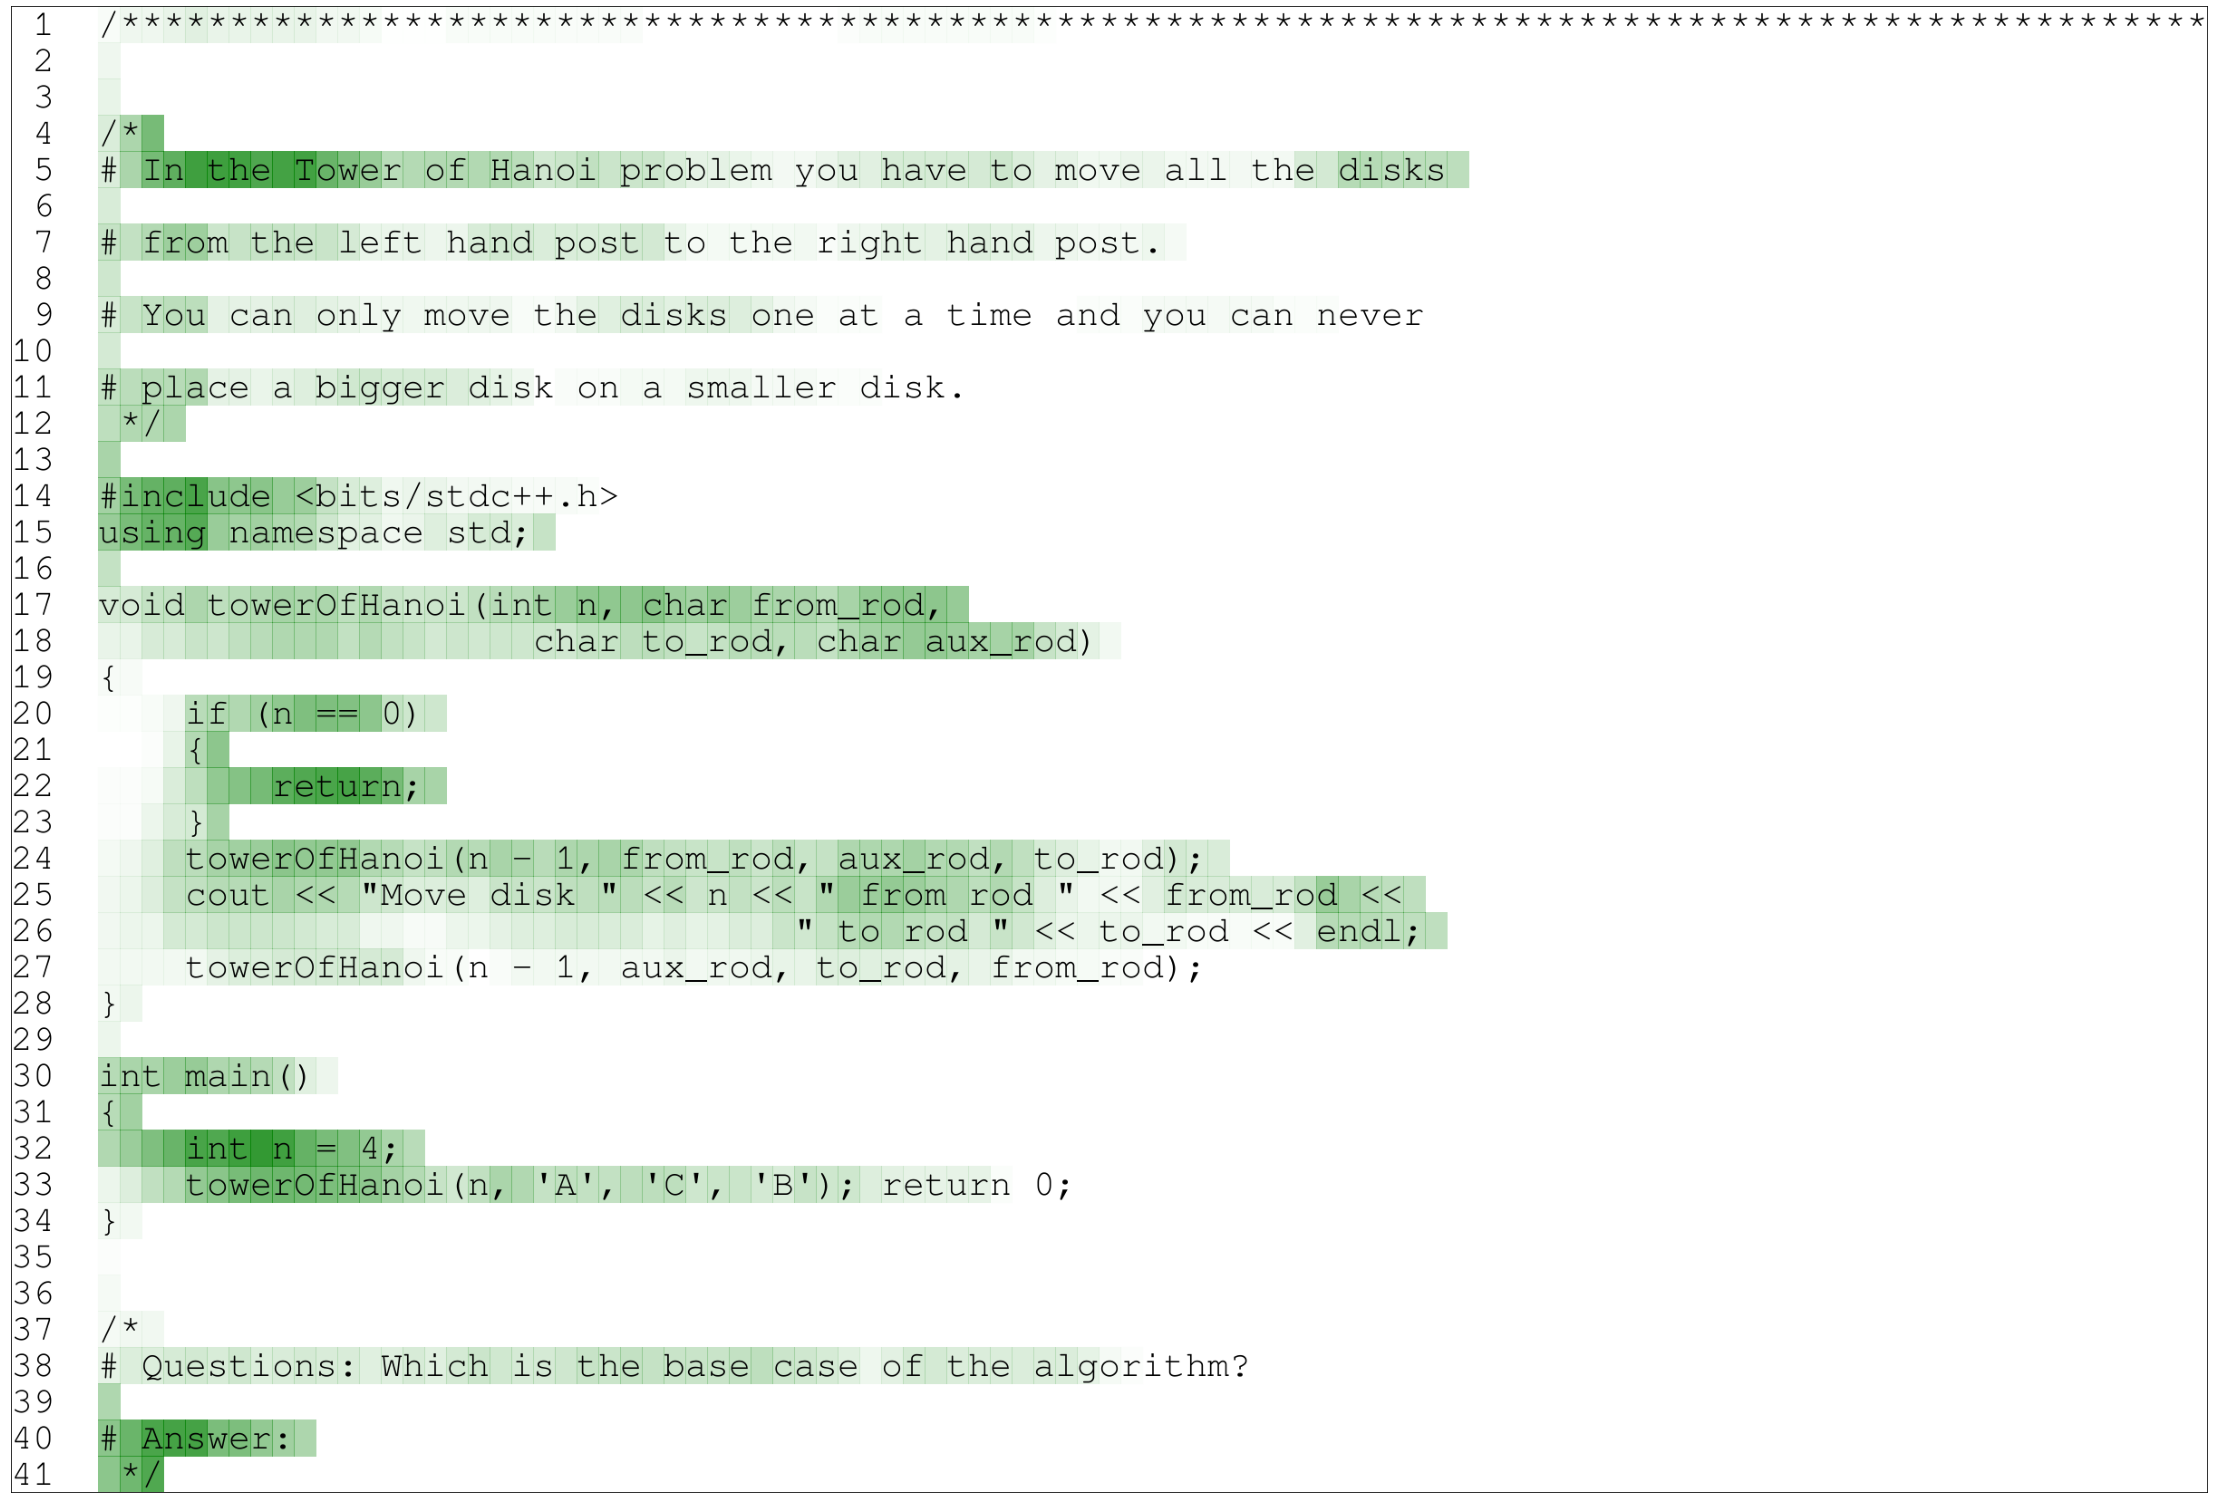

In [10]:
# visualize attention weights for human
from codeattention.source_code import SourceCode

hum_code = SourceCode(tokens=human_data["tokenization"])
hum_code.show_with_weights(
    weights=human_data["att_weights"],
    show_line_numbers=True,
)

## CodeGen

In [11]:
from attwizard.decoder import condense_attention
import torch

# condense att weigths
att_matrix = torch.amax(
    input=torch.tensor(model_att_data),
    dim=[0, 1]
)
att_matrix.shape

torch.Size([380, 380])

(<Figure size 720x720 with 2 Axes>, <AxesSubplot:>)

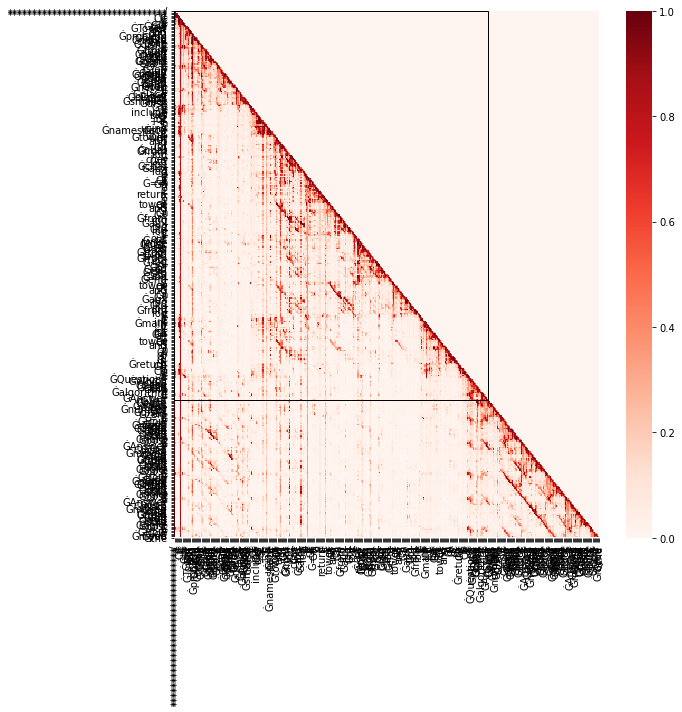

In [12]:
import seaborn as sns
from attwizard.decoder import heatmap_visualize

heatmap_visualize(
    attention_matrix=att_matrix,
    token_names=model_pred_data["tokens_all"],
    n_input_tokens=len(model_pred_data["tokens_prompt"])
)

In [13]:
CUT_POINT = "answer"  # "question" | "answer", "precise_answer"


if CUT_POINT == "question":
    print("Cut the matrices to account only the attention that the QUESTION tokens give to the prompt.")
    print("Aka between: ĠQuestions token and ĠAnswer token")
    # get the token index of the "# Question: " token
    question_token_index = model_pred_data["tokens_prompt"].index("ĠQuestions")
    answer_token_index = model_pred_data["tokens_all"].index("ĠAnswer")
    first_index = question_token_index
    end_index = answer_token_index
elif CUT_POINT == "answer":
    print("Cut the matrices to account only for the tokens in the ANSWER.")
    print("Aka after : ĠAnswer token.")
    # get the token index of the "# Answer: " token
    answer_token_index = model_pred_data["tokens_all"].index("ĠAnswer")
    first_index = answer_token_index
    end_index = None
elif CUT_POINT == "precise_answer":
    print("Cut the matrices to account only for the tokens in the PRECISE answer.")
    print("Aka after the last occurence of : Ġbase token.")
    # get the token index of the "# Answer: " token
    answer_token_index = model_pred_data["tokens_all"][::-1].index("Ġbase")
    first_index = answer_token_index
    end_index = None

if end_index:
    focused_att_matrix = att_matrix[first_index:end_index, :]
else:
    focused_att_matrix = att_matrix[first_index:, :]

print(focused_att_matrix.shape)


print("Condensed each token receives the mean attention that the subsequent tokens give to it.")
print("Summing over the columns...")
model_att_weigth_vector = list(focused_att_matrix.sum(axis=0).numpy())
denominator_vector = np.arange(len(model_att_weigth_vector), 0, -1)
model_att_weigth_vector = model_att_weigth_vector / denominator_vector
print("Dividing by this denominators...")
print(len(denominator_vector))
print(denominator_vector[:5], denominator_vector[-5:])
# append 1 because the last token is unattended, it is simply generated 
# attending the previous ones.
model_att_weigth_vector = list(model_att_weigth_vector)
model_att_weigth_vector.append(0)



print("Total tokens: ", len(model_pred_data["tokens_all"]))


print("Prompt tokens: ", len(model_pred_data["tokens_prompt"]))
model_att_weigth_vector = model_att_weigth_vector[:len(model_pred_data["tokens_prompt"])]
print("Artificailly zero the attention on the tokens themselves because they obviously attend themselves more... (and the preceeding char)")
model_att_weigth_vector = np.array(model_att_weigth_vector)
print("Index: ", first_index)
model_att_weigth_vector[first_index-1:] = 0

N_TOKENS_START_ZEROING = 20
print("ZEROS the first {N_TOKENS_START_ZEROING} tokens, to avoid bias towards the first tokens.")
model_att_weigth_vector[:N_TOKENS_START_ZEROING] = 0

model_att_weigth_vector = list(model_att_weigth_vector)
print("Total PROMPT-ONLY weights: ", len(model_att_weigth_vector))

Cut the matrices to account only for the tokens in the ANSWER.
Aka after : ĠAnswer token.
torch.Size([101, 380])
Condensed each token receives the mean attention that the subsequent tokens give to it.
Summing over the columns...
Dividing by this denominators...
380
[380 379 378 377 376] [5 4 3 2 1]
Total tokens:  381
Prompt tokens:  281
Artificailly zero the attention on the tokens themselves because they obviously attend themselves more... (and the preceeding char)
Index:  279
ZEROS the first {N_TOKENS_START_ZEROING} tokens, to avoid bias towards the first tokens.
Total PROMPT-ONLY weights:  281


IDEA: sum only over the last lines.

In [14]:
print("Model prediction:")
print(model_pred_data["text_generated"])

Model prediction:
/*************************************************************************************************/


/*
# In the Tower of Hanoi problem you have to move all the disks

# from the left hand post to the right hand post.

# You can only move the disks one at a time and you can never

# place a bigger disk on a smaller disk.
 */

#include <bits/stdc++.h>
using namespace std;

void towerOfHanoi(int n, char from_rod,
                    char to_rod, char aux_rod)
{
    if (n == 0)
    {
        return;
    }
    towerOfHanoi(n - 1, from_rod, aux_rod, to_rod);
    cout << "Move disk " << n << " from rod " << from_rod <<
                                " to rod " << to_rod << endl;
    towerOfHanoi(n - 1, aux_rod, to_rod, from_rod);
}

int main()
{
    int n = 4;
    towerOfHanoi(n, 'A', 'C', 'B'); return 0;
}


/*
# Questions: Which is the base case of the algorithm?

# Answer: The base case is when the number of disks is zero.

# How do you move the disks from the left pos

This considers only the prompt itself, not the generated code.


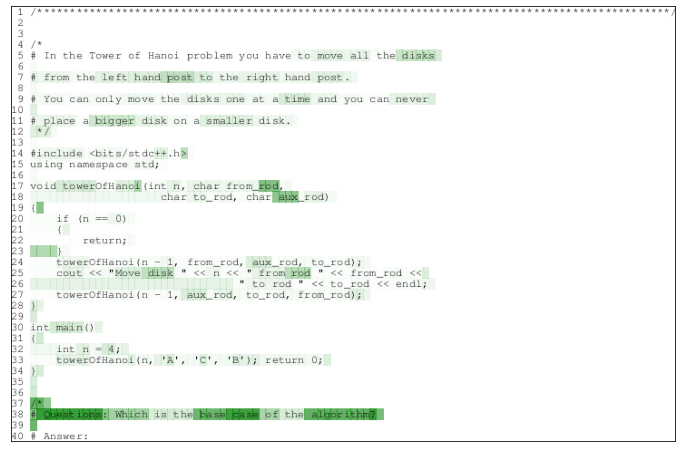

In [15]:
from attwizard.decoder import get_attention_representation
from attwizard.aligner import map_to_char_level
from attwizard.aligner import tokenize_char_level

# convert the attntion to char level (easier to compare and display)
att_weights_char_level = map_to_char_level(
    tokens=model_pred_data["tokens_prompt"],
    att_weights=model_att_weigth_vector,
    raw_text=model_pred_data["text_prompt"],
    #distribution_fn="equal_share",
    distribution_fn="replication",
    special_char_mapping={
        "Ġ": ' ',
        "Ċ": '\n',
    }
)
char_tokens = tokenize_char_level(model_pred_data["text_prompt"])
# display
python_sc = SourceCode(char_tokens)
fig, ax = python_sc.show_with_weights(
    weights=att_weights_char_level,
    show_line_numbers=True,
    char_height=12,
)
print('This considers only the prompt itself, not the generated code.')

Suggestions:
- consider only the attention given to by the other tokens
- take into account recency effects (e.g. multiply each line times a costant depending on the recency of that token, early token get boosted more)
- and token types (e.g. spaces are less intresting than words) or the attention is shifted towards the end of the line. e.g malus for end of the line.
- compute single line attention. Reconstruct the attention matrix between lines.


- interested in predicting the attention from A to B.

# Compute Correlation

try JSD divergence

In [16]:
from scipy.stats import spearmanr

print("Char in the human data: ", len(human_data["att_weights"]))
print("Char in the model data: ", len(att_weights_char_level))

Char in the human data:  885
Char in the model data:  884


In [17]:
human_vector = np.array(human_data["att_weights"][:-1])
model_vector = np.array(att_weights_char_level)
print("Human vector: ", human_vector.shape)
print("Model vector: ", model_vector.shape)
correlation = spearmanr(human_vector, model_vector)
print("Correlation: ", correlation)

Human vector:  (884,)
Model vector:  (884,)
Correlation:  SpearmanrResult(correlation=0.11472738408106699, pvalue=0.0006318651859655583)


## Batch 1 - Eye Tracking Data


In [18]:
FOLDER_EYE_DATA = f"../data/eye_tracking_attention/{HUMAN_EXPERIMENT}"
FOLDER_MODEL_PREDICTION = f"../data/model_output/{MACHINE_EXPERIMENT}"
MODEL_NAME = "Salesforce/codegen-16B-multi"
ESCAPED_MODEL_NAME = MODEL_NAME.replace("/", "_")

PATH_INTERMEDIATE_ATT_MATRICES = os.path.join(
    FOLDER_MODEL_PREDICTION,
    "att_matrices_max_" + ESCAPED_MODEL_NAME + ".torch_pickle")

In [38]:
# ITERATE OVER THE EYE DATA
eye_data_json_files = [
    f for f in os.listdir(FOLDER_EYE_DATA)
    if f.endswith(".json") and not f.endswith("_model.json")]
eye_data = []
for json_filename in eye_data_json_files:
    # READ HUMAN DATA
    eye_data_file_path = os.path.join(FOLDER_EYE_DATA, json_filename)
    user_task_eye_data = json.load(open(eye_data_file_path, 'r'))
    eye_data.append(user_task_eye_data)


In [20]:
# check it the att_matrices file exists
if os.path.exists(PATH_INTERMEDIATE_ATT_MATRICES):
    # load the att_matrices
    att_matrices = torch.load(PATH_INTERMEDIATE_ATT_MATRICES)
else:
    # READ THE FULL ATTENTION TENSOR AND DERIVE ATT MATRICES

    # ITERATE OVER THE MODEL PREDICTION DATA
    model_data_npy_files = [
        f for f in os.listdir(FOLDER_MODEL_PREDICTION) if f.endswith(".npy")]

    att_tensors = {}
    # READ MODEL DATA - CORRESPOMDING TO THE SAME PROMPT
    for npy_filename in tqdm(model_data_npy_files):
        filename = \
            npy_filename.replace(".npy", "").replace("_" + ESCAPED_MODEL_NAME, "")
        att_tensors[filename] = np.load(
            os.path.join(FOLDER_MODEL_PREDICTION, npy_filename))
    # GENREATE THE CORRESPONDING ATTENTION MATRICES 
    att_matrices = {}
    print("Condensing with the MAX weight on each layer and on each head.")
    for k, v in tqdm(att_tensors.items()):
        att_matrices[k] = torch.amax(
            input=torch.tensor(v),
            dim=[0, 1])
    # Store attention matrices as intermediate cache
    torch.save(
        att_matrices, PATH_INTERMEDIATE_ATT_MATRICES)


100%|██████████| 45/45 [12:47<00:00, 17.06s/it]


Condensing with the MAX weight on each layer and on each head.


100%|██████████| 45/45 [00:02<00:00, 18.30it/s]


In [30]:
# READ METADATA

metadata = {}
eye_data_json_files = [
    f for f in os.listdir(FOLDER_MODEL_PREDICTION) 
    if f.endswith(".json") and not f.endswith("_model.json")]
print(eye_data_json_files)
for metadata_json_filename in eye_data_json_files:
    filename = \
        metadata_json_filename.replace(".json", "").replace("_" + ESCAPED_MODEL_NAME, "")
    metadata[filename] = json.load(open(
            os.path.join(FOLDER_MODEL_PREDICTION, metadata_json_filename)))

['Nqueens_Q1.cpp_Salesforce_codegen-16B-multi.json', 'Nqueens_Q1.cs_Salesforce_codegen-16B-multi.json', 'Nqueens_Q1.py_Salesforce_codegen-16B-multi.json', 'Nqueens_Q2.cpp_Salesforce_codegen-16B-multi.json', 'Nqueens_Q2.cs_Salesforce_codegen-16B-multi.json', 'Nqueens_Q2.py_Salesforce_codegen-16B-multi.json', 'Nqueens_Q3.cpp_Salesforce_codegen-16B-multi.json', 'Nqueens_Q3.cs_Salesforce_codegen-16B-multi.json', 'Nqueens_Q3.py_Salesforce_codegen-16B-multi.json', 'countprimes_Q1.cpp_Salesforce_codegen-16B-multi.json', 'countprimes_Q2.cpp_Salesforce_codegen-16B-multi.json', 'countprimes_Q3.cpp_Salesforce_codegen-16B-multi.json', 'hannoi_Q1.cpp_Salesforce_codegen-16B-multi.json', 'hannoi_Q1.cs_Salesforce_codegen-16B-multi.json', 'hannoi_Q1.py_Salesforce_codegen-16B-multi.json', 'hannoi_Q2.cpp_Salesforce_codegen-16B-multi.json', 'hannoi_Q2.cs_Salesforce_codegen-16B-multi.json', 'hannoi_Q2.py_Salesforce_codegen-16B-multi.json', 'hannoi_Q3.cpp_Salesforce_codegen-16B-multi.json', 'hannoi_Q3.cs_Sa

## Prepare processing functions

In [31]:
# EXCLUSTION FUNCTIONS
# to exclude certain tokens from the attention matrix condensation

def excude_specific_tokens(
        a: torch.tensor, 
        tokens_prompt: List[str] = None,
        tokens_all: List[str] = None,
        tokens_to_exclude: List[str] = []) -> torch.tensor:
    """Exclude specific tokens."""
    mask = torch.tensor([t in tokens_to_exclude for t in tokens_all])
    expanded_mask = mask.expand(x.shape[1], x.shape[0]).t()
    return x[expanded_mask].reshape(-1, x.shape[1])


def excude_end_of_lines(
        a: torch.tensor, 
        tokens_prompt: List[str] = None,
        tokens_all: List[str] = None,
        eol_token: str = "Ċ") -> torch.tensor:
    """Exclude the end of lines."""
    return excude_specific_tokens(a, tokens_prompt, tokens_all, [eol_token])


def excude_spaces(
        a: torch.tensor, 
        tokens_prompt: List[str] = None,
        tokens_all: List[str] = None,
        space_token: str = "Ġ") -> torch.tensor:
    """Exclude the spaces."""
    return excude_specific_tokens(a, tokens_prompt, tokens_all, [space_token])


def exclude_spaces_and_end_of_lines(
        a: torch.tensor, 
        tokens_prompt: List[str] = None,
        tokens_all: List[str] = None,
        space_token: str = "Ġ",
        eol_token: str = "Ċ") -> torch.tensor:
    """Exclude the spaces and the end of lines."""
    return excude_specific_tokens(
        a, tokens_prompt, tokens_all, [space_token, eol_token])

In [32]:
# PROCESSING LEVEL 0
# processing which do no eliminate any line or columns, but rather zero out 
# some attention weights.
# They can be perofrmed only at the very beginning when the attention matrix
# is square and contains all tokens.

def zeroe_attention_on_itself(
        a: torch.Tensor,
        all_tokens: List[str],
        tokens_prompt: List[str]):
    """For each token, remove the attention it gives to itself."""
    return a - torch.eye(a.shape[0])

In [33]:
# RESTRICTION FUNCTIONS:
# to reduce the attention matrix to only relevant sections

def focus_on_entire_prompt_and_generated_text(
        a: torch.tensor, 
        tokens_prompt: List[str] = None,
        tokens_all: List[str] = None) -> torch.tensor:
    """Focus on the entire prompt and generated text."""
    return a


def focus_on_entire_prompt(
        a: torch.tensor, 
        tokens_prompt: List[str] = None,
        tokens_all: List[str] = None) -> torch.tensor:
    """Focus on the entire prompt only."""
    return a[:len(tokens_prompt), :]


def focus_on_question(
        a: torch.tensor, 
        tokens_prompt: List[str] = None,
        tokens_all: List[str] = None,
        question_token: str = "ĠQuestion") -> torch.tensor:
    """Focus only on the question part of the prompt."""
    try:
        idx_question_token = \
            len(tokens_prompt) - tokens_prompt[::-1].index(question_token)
    except ValueError as e:
        idx_question_token = \
            len(tokens_prompt) - tokens_prompt[::-1].index("ĠQuestions")
    return a[idx_question_token:len(tokens_prompt), :]


def focus_on_new_generated_text(
        a: torch.tensor, 
        tokens_prompt: List[str] = None,
        tokens_all: List[str] = None,) -> torch.tensor:
    """Focus only on the newly generated text."""
    return a[len(tokens_prompt):, :]



In [34]:
# PROCESSING FUNCTION:
# to derive a vector from the attention matrix

def normalize_per_recency(a: torch.tensor) -> torch.tensor:
    """Boost the attention weights by the recency of the token.
    
    It multiplies the attention weights of a given token (aka matrix line)
    by the number of tokens before it (aka matrix line index)."""
    n_tokens_from = a.shape[0]
    n_tokens_to = a.shape[1]
    # create multiplicative mask
    multiplicative_sequence = torch.arange(1, n_tokens_from + 1) ** 0.5
    mult_mask = multiplicative_sequence.expand(n_tokens_to, n_tokens_from).t()
    return a * mult_mask

def normalize_per_recency_and_sum(a: torch.tensor) -> List[float]:
    """Boost the attention weights by the recency of the token."""
    return normalize_per_recency(a).sum(dim=0).tolist()


def normalize_per_recency_and_max(a: torch.tensor) -> List[float]:
    """Boost the attention weights by the recency of the token."""
    return normalize_per_recency(a).amax(dim=0).tolist()


def mean_att_from_followers(a: torch.tensor) -> List[float]:
    """Take the mean att that each toke receives from its followers."""
    denominator_sequence = torch.count_nonzero(a, dim=0)
    # avoid division by zero
    denominator_sequence = torch.max(
        torch.tensor(1.0), denominator_sequence)
    sum_vector = torch.sum(a, dim=0)
    return (sum_vector / denominator_sequence).tolist()

x = torch.tensor([
        [1, 0, 0],
        [4, 5, 0],
])

mean_att_from_followers(x)

[2.5, 5.0, 0.0]

In [35]:
att_matrices.keys()

dict_keys(['Nqueens_Q1.cpp', 'Nqueens_Q1.cs', 'Nqueens_Q1.py', 'Nqueens_Q2.cpp', 'Nqueens_Q2.cs', 'Nqueens_Q2.py', 'Nqueens_Q3.cpp', 'Nqueens_Q3.cs', 'Nqueens_Q3.py', 'countprimes_Q1.cpp', 'countprimes_Q2.cpp', 'countprimes_Q3.cpp', 'hannoi_Q1.cpp', 'hannoi_Q1.cs', 'hannoi_Q1.py', 'hannoi_Q2.cpp', 'hannoi_Q2.cs', 'hannoi_Q2.py', 'hannoi_Q3.cpp', 'hannoi_Q3.cs', 'hannoi_Q3.py', 'scheduler_Q1.cs', 'scheduler_Q1.py', 'scheduler_Q2.cs', 'scheduler_Q2.py', 'scheduler_Q3.cs', 'scheduler_Q3.py', 'tree_Q1.cpp', 'tree_Q1.cs', 'tree_Q1.py', 'tree_Q2.cpp', 'tree_Q2.cs', 'tree_Q2.py', 'tree_Q3.cpp', 'tree_Q3.cs', 'tree_Q3.py', 'triangle_Q1.cpp', 'triangle_Q1.cs', 'triangle_Q1.py', 'triangle_Q2.cpp', 'triangle_Q2.cs', 'triangle_Q2.py', 'triangle_Q3.cpp', 'triangle_Q3.cs', 'triangle_Q3.py'])

In [36]:

att_matrices["Nqueens_Q2.cs"].shape

torch.Size([721, 721])

# Loop over matrices

In [41]:
RESTRICTION_FUNCTONS = [
    focus_on_entire_prompt,
    focus_on_entire_prompt_and_generated_text,
    focus_on_question,
    focus_on_new_generated_text,   
]
ATT_EXTRACTION_FUNCTIONS = [
    normalize_per_recency_and_sum,
    normalize_per_recency_and_max,
    mean_att_from_followers,
]

all_records_results = []

for i_human_data in tqdm(range(len(eye_data))):
    c_human_data = eye_data[i_human_data]
    print(c_human_data["user_name"], " - ", c_human_data["source_code"])
    c_file_name = os.path.basename(c_human_data["source_code"])
    #print(f"{i_human_data}) {c_file_name}")
    try:
        a = att_matrices[c_file_name]
    except KeyError as e:
        print(f"{c_file_name} not found in att_matrices")
        continue
    meta = metadata[c_file_name]

    for restr_fn in RESTRICTION_FUNCTONS:
        #print(restr_fn.__name__)
        # FOCUS ONLY ON SOME AREAS 
        # use only their attention weights
        restricted_att = restr_fn(
            a, tokens_prompt=meta["tokens_prompt"], tokens_all=meta["tokens_all"])
        # EXCLUDE SOME CHARACTERS
        # TODO
        #sns.heatmap(restricted_att, cmap="Reds")
        #plt.title(restr_fn.__name__)
        #plt.show()
        # GET ATTENTION WEIGHTS (VECTOR)
        for att_fn in ATT_EXTRACTION_FUNCTIONS:
            #print(att_fn.__name__)
            model_att_weigth_vector = att_fn(restricted_att)
            # CONVERT TO CHARACTER VECTOR
            n_weigth_under_consideration = len(model_att_weigth_vector)
            n_tokens_in_prompt = len(meta["tokens_prompt"])
            #print(
            #    f"n_weigth_under_consideration: {n_weigth_under_consideration}",
            #    f"  - n_tokens_in_prompt: {n_tokens_in_prompt}") 
            for mapping_from_token_to_char in ["equal_share", "replication"]:
                model_att_weigth_vector_char = map_to_char_level(
                    tokens=meta["tokens_prompt"],
                    att_weights=model_att_weigth_vector,
                    raw_text=meta["text_prompt"],
                    distribution_fn=mapping_from_token_to_char,
                    special_char_mapping={
                        "Ġ": ' ',
                        "Ċ": '\n',
                    }
                )
                # COMPUTE CORRELATION
                human_vector = np.array(c_human_data["att_weights"][:-1])
                n_char_for_human = len(human_vector)
                model_vector = np.array(model_att_weigth_vector_char[:n_char_for_human])
                try:
                    correlation = spearmanr(human_vector, model_vector)
                except ValueError as e:
                    print(e)
                    continue
                #print("Human vector: ", human_vector.shape, 
                #      " - Model vector: ", model_vector.shape,
                #      " - Correlation: ", correlation)
                new_record = {
                    "source_code": c_file_name,
                    "user_name": c_human_data["user_name"],
                    "task_number": c_human_data["task_number"],
                    "restriction_function": restr_fn.__name__,
                    "extraction_function": att_fn.__name__,
                    "mapping_from_token_to_char": mapping_from_token_to_char,
                    "correlation": correlation.correlation,
                    "pvalue": correlation.pvalue,
                }
                all_records_results.append(new_record)


df_res = pd.DataFrame.from_records(all_records_results)



  0%|          | 0/38 [00:00<?, ?it/s]

UbagU  -  python/hannoi_Q2.py
UbagU  -  python/tree_Q2.py


  8%|▊         | 3/38 [00:00<00:04,  7.53it/s]

UbagU  -  python/triangle_Q1.py
UbagU  -  python/multithread_Q1.py
multithread_Q1.py not found in att_matrices
UbeerU  -  python/hannoi_Q1.py


 16%|█▌        | 6/38 [00:00<00:02, 11.15it/s]

UbeerU  -  python/tree_Q1.py
UbeerU  -  python/triangle_Q3.py


 26%|██▋       | 10/38 [00:00<00:02, 12.23it/s]

UbeerU  -  python/multithread_Q2.py
multithread_Q2.py not found in att_matrices
UbottleU  -  python/hannoi_Q2.py
UbottleU  -  python/tree_Q2.py
UbottleU  -  python/triangle_Q1.py


 37%|███▋      | 14/38 [00:01<00:01, 12.43it/s]

UbottleU  -  python/multithread_Q1.py
multithread_Q1.py not found in att_matrices
UconsumerU  -  cpp/hannoi_Q2.cpp
UconsumerU  -  cpp/Nqueens_Q3.cpp
UconsumerU  -  cpp/tree_Q3.cpp
all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 1864 and the array at index 1 has size 1862
all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 1864 and the array at index 1 has size 1862
all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 1864 and the array at index 1 has size 1862
all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 1864 and the array at index 1 has size 1862
all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 

 47%|████▋     | 18/38 [00:01<00:01, 10.31it/s]

UdragonU  -  cpp/hannoi_Q1.cpp
UdragonU  -  cpp/tree_Q2.cpp
all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 1796 and the array at index 1 has size 1794
all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 1796 and the array at index 1 has size 1794
all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 1796 and the array at index 1 has size 1794
all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 1796 and the array at index 1 has size 1794
all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 1796 and the array at index 1 has size 1794
all the input array dimensions for the concatenation axis must ma

 53%|█████▎    | 20/38 [00:01<00:01, 10.87it/s]

all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 1810 and the array at index 1 has size 1808
all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 1810 and the array at index 1 has size 1808
all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 1810 and the array at index 1 has size 1808
all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 1810 and the array at index 1 has size 1808
all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 1810 and the array at index 1 has size 1808
all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has

 58%|█████▊    | 22/38 [00:01<00:01, 11.14it/s]

UimproveU  -  python/Nqueens_Q1.py
UimproveU  -  python/triangle_Q1.py


 63%|██████▎   | 24/38 [00:02<00:01, 10.84it/s]

UmonkU  -  cpp/hannoi_Q1.cpp
UmonkU  -  cpp/Nqueens_Q3.cpp
UmonkU  -  cpp/triangle_Q1.cpp
all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 1809 and the array at index 1 has size 1808


 68%|██████▊   | 26/38 [00:02<00:01,  9.89it/s]

all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 1809 and the array at index 1 has size 1808
all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 1809 and the array at index 1 has size 1808
all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 1809 and the array at index 1 has size 1808
all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 1809 and the array at index 1 has size 1808
all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 1809 and the array at index 1 has size 1808
all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has

 74%|███████▎  | 28/38 [00:02<00:01,  9.91it/s]

UpassionU  -  csharp/hannoi_Q3.cs
UpassionU  -  csharp/Nqueens_Q1.cs


 79%|███████▉  | 30/38 [00:02<00:00,  8.87it/s]

UpassionU  -  csharp/triangle_Q3.cs
UquarterU  -  cpp/hannoi_Q1.cpp


 84%|████████▍ | 32/38 [00:03<00:00,  9.03it/s]

UquarterU  -  cpp/Nqueens_Q2.cpp
UquarterU  -  cpp/tree_Q3.cpp
all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 1864 and the array at index 1 has size 1862
all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 1864 and the array at index 1 has size 1862
all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 1864 and the array at index 1 has size 1862
all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 1864 and the array at index 1 has size 1862
all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 1864 and the array at index 1 has size 1862
all the input array dimensions for the concatenation axis must

 87%|████████▋ | 33/38 [00:03<00:00,  8.48it/s]

all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 1864 and the array at index 1 has size 1862
all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 1864 and the array at index 1 has size 1862
all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 1864 and the array at index 1 has size 1862
all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 1864 and the array at index 1 has size 1862
all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 1864 and the array at index 1 has size 1862
all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has

 92%|█████████▏| 35/38 [00:03<00:00,  7.87it/s]

all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 1810 and the array at index 1 has size 1808
all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 1810 and the array at index 1 has size 1808
all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 1810 and the array at index 1 has size 1808
all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 1810 and the array at index 1 has size 1808
all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 1810 and the array at index 1 has size 1808
all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has

 97%|█████████▋| 37/38 [00:03<00:00,  6.68it/s]

UsalvationU  -  csharp/tree_Q1.cs
UsalvationU  -  csharp/triangle_Q2.cs


100%|██████████| 38/38 [00:04<00:00,  9.25it/s]


In [42]:
print(len(df_res))
df_res.head()

672


source_code user_name  task_number    restriction_function  \
0  hannoi_Q2.py     UbagU            0  focus_on_entire_prompt   
1  hannoi_Q2.py     UbagU            0  focus_on_entire_prompt   
2  hannoi_Q2.py     UbagU            0  focus_on_entire_prompt   
3  hannoi_Q2.py     UbagU            0  focus_on_entire_prompt   
4  hannoi_Q2.py     UbagU            0  focus_on_entire_prompt   

             extraction_function mapping_from_token_to_char  correlation  \
0  normalize_per_recency_and_sum                equal_share     0.423872   
1  normalize_per_recency_and_sum                replication     0.192633   
2  normalize_per_recency_and_max                equal_share     0.413566   
3  normalize_per_recency_and_max                replication     0.209238   
4        mean_att_from_followers                equal_share     0.329283   

         pvalue  
0  1.344393e-29  
1  7.946675e-07  
2  4.026091e-28  
3  7.808671e-08  
4  7.936892e-18

In [43]:
df_legit_res = df_res[df_res["pvalue"] <= 0.05]


In [44]:
def visualize_corr_vs(
        df: pd.DataFrame,  
        col_to_inspect: str,
        corr_col: str = "correlation"):
    """Check the relationship between correlation and the given variable."""
    fig, axes = plt.subplots(2, 1, figsize=(10, 5))
    ax_hist = axes[0]
    ax_violin = axes[1]
    # HISTGRAM
    sns.histplot(
        data=df_legit_res,
        x=corr_col,
        multiple="stack",
        hue=col_to_inspect,
        ax= ax_hist,
    )
    ax_hist.axvline(0, color="red", linestyle="--")
    ax_hist.set_xlim(-1, 1)
    # VIOLINPLOT
    sns.violinplot(
        data=df_legit_res,
        x=corr_col,
        y=col_to_inspect
    )
    ax_violin.set_xlim(-1, 1)
    plt.tight_layout()


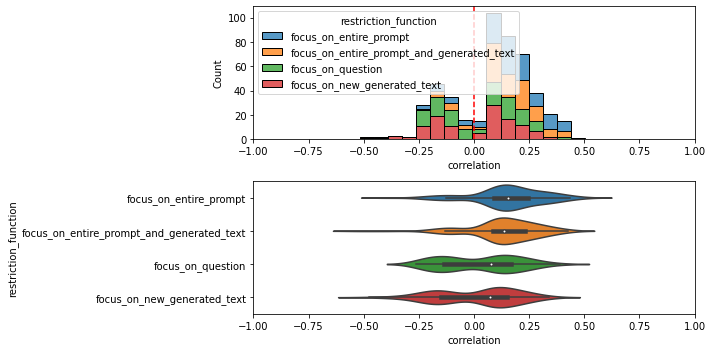

In [45]:
visualize_corr_vs(
    df_legit_res,
    col_to_inspect="restriction_function",
)

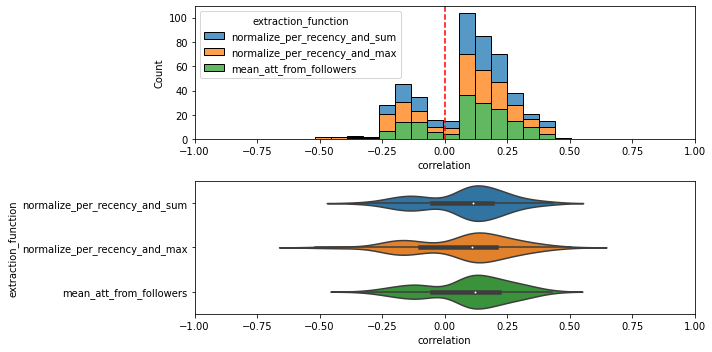

In [46]:
visualize_corr_vs(
    df_legit_res,
    col_to_inspect="extraction_function",
)

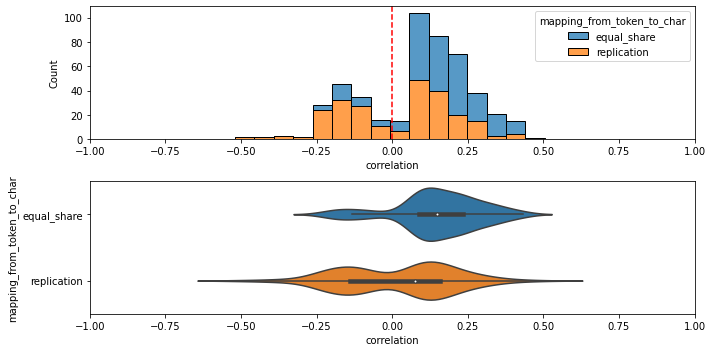

In [47]:
visualize_corr_vs(
    df_legit_res,
    col_to_inspect="mapping_from_token_to_char",
)

(-1.0, 1.0)

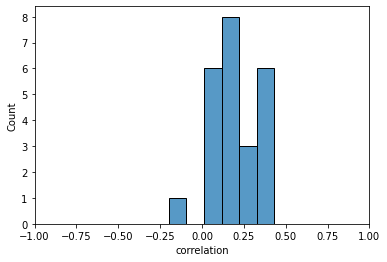

In [48]:
df_best_selection = df_legit_res[
    (df_legit_res["mapping_from_token_to_char"] == "equal_share") &
    (df_legit_res["extraction_function"] == "mean_att_from_followers") &
    (df_legit_res["restriction_function"] == "focus_on_entire_prompt")
]

sns.histplot(
    data=df_best_selection,
    x="correlation"
)
plt.xlim(-1, 1)

# Inter-Rater Agreement

In [49]:
map_snippet_to_humans = {}
map_snippet_to_human_data = {}

for i_human_data in tqdm(range(len(eye_data))):
    c_human_data = eye_data[i_human_data]
    source_snippet = c_human_data["source_code"]
    if source_snippet not in map_snippet_to_humans.keys():
        map_snippet_to_humans[source_snippet] = [i_human_data]
        map_snippet_to_human_data[source_snippet] = [c_human_data]
    else:
        map_snippet_to_humans[source_snippet] += [i_human_data]
        map_snippet_to_human_data[source_snippet] += [c_human_data]


map_snippet_to_humans

100%|██████████| 38/38 [00:00<00:00, 196769.82it/s]


{'python/hannoi_Q2.py': [0, 8],
 'python/tree_Q2.py': [1, 9],
 'python/triangle_Q1.py': [2, 10, 22],
 'python/multithread_Q1.py': [3, 11],
 'python/hannoi_Q1.py': [4],
 'python/tree_Q1.py': [5],
 'python/triangle_Q3.py': [6],
 'python/multithread_Q2.py': [7],
 'cpp/hannoi_Q2.cpp': [12],
 'cpp/Nqueens_Q3.cpp': [13, 24],
 'cpp/tree_Q3.cpp': [14, 32],
 'cpp/triangle_Q3.cpp': [15],
 'cpp/hannoi_Q1.cpp': [16, 23, 30],
 'cpp/tree_Q2.cpp': [17, 26],
 'cpp/triangle_Q1.cpp': [18, 25, 33],
 'cpp/multithread_Q2.cpp': [19],
 'python/hannoi_Q3.py': [20],
 'python/Nqueens_Q1.py': [21],
 'csharp/hannoi_Q3.cs': [27],
 'csharp/Nqueens_Q1.cs': [28],
 'csharp/triangle_Q3.cs': [29],
 'cpp/Nqueens_Q2.cpp': [31],
 'csharp/hannoi_Q2.cs': [34],
 'csharp/Nqueens_Q3.cs': [35],
 'csharp/tree_Q1.cs': [36],
 'csharp/triangle_Q2.cs': [37]}

In [50]:
from itertools import combinations

all_human_human_records = []

for filename, humans_with_same_task in map_snippet_to_human_data.items():
    if len(humans_with_same_task) > 1:
        print(filename, len(humans_with_same_task))
        # for each combination of humans
        all_combinations = combinations(humans_with_same_task, 2)
        for c_combination in all_combinations:
            human_a = c_combination[0]
            human_b = c_combination[1]
            print(human_a["user_name"], human_b["user_name"])
            human_vector_a = np.array(human_a["att_weights"])
            human_vector_b = np.array(human_b["att_weights"])
            # the two people might have had slightly different input files
            # so we discard those comparisons for now
            if len(human_vector_a) != len(human_vector_b):
                print("Skipping comparison because of different lengths")
                continue
            correlation = spearmanr(human_vector_a, human_vector_b)
            new_record = {
                "source_code": filename,
                "human_a": human_a["user_name"],
                "human_b": human_b["user_name"],
                "task_nr_a": human_a["task_number"],
                "task_nr_b": human_b["task_number"],
                "correlation": correlation.correlation,
                "pvalue": correlation.pvalue,
            }
            all_human_human_records.append(new_record)

df_human_human_res = pd.DataFrame.from_records(all_human_human_records)
df_human_human_res.head()

python/hannoi_Q2.py 2
UbagU UbottleU
Skipping comparison because of different lengths
python/tree_Q2.py 2
UbagU UbottleU
python/triangle_Q1.py 3
UbagU UbottleU
UbagU UimproveU
Skipping comparison because of different lengths
UbottleU UimproveU
Skipping comparison because of different lengths
python/multithread_Q1.py 2
UbagU UbottleU
Skipping comparison because of different lengths
cpp/Nqueens_Q3.cpp 2
UconsumerU UmonkU
Skipping comparison because of different lengths
cpp/tree_Q3.cpp 2
UconsumerU UquarterU
cpp/hannoi_Q1.cpp 3
UdragonU UmonkU
Skipping comparison because of different lengths
UdragonU UquarterU
UmonkU UquarterU
Skipping comparison because of different lengths
cpp/tree_Q2.cpp 2
UdragonU UmonkU
Skipping comparison because of different lengths
cpp/triangle_Q1.cpp 3
UdragonU UmonkU
Skipping comparison because of different lengths
UdragonU UquarterU
UmonkU UquarterU
Skipping comparison because of different lengths


source_code     human_a    human_b  task_nr_a  task_nr_b  \
0      python/tree_Q2.py       UbagU   UbottleU          2          1   
1  python/triangle_Q1.py       UbagU   UbottleU          3          2   
2        cpp/tree_Q3.cpp  UconsumerU  UquarterU          2          2   
3      cpp/hannoi_Q1.cpp    UdragonU  UquarterU          1          0   
4    cpp/triangle_Q1.cpp    UdragonU  UquarterU          3          3   

   correlation         pvalue  
0     0.449648   3.384362e-87  
1     0.637653  1.162031e-156  
2    -0.074040   1.375681e-03  
3     0.832739  1.934267e-238  
4     0.586964  3.782160e-168

In [51]:
c_human_data.keys()

dict_keys(['user_name', 'task_number', 'source_code', 'att_weights', 'tokenization', 'raw_text'])

## Side by Side comparison

In [47]:
# compare two attention maps side by side
def visualize_human_att_maps(path_human_a, path_human_b):
    """Visualize the attention maps of two humans."""
    human_a = json.load(open(path_human_a, 'r'))
    human_b = json.load(open(path_human_b, 'r'))
    for human_data in [human_a, human_b]:
        source = SourceCode(
            tokens=human_data["tokenization"]
        )
        source.show_with_weights(
            weights=human_data["att_weights"],
            show_line_numbers=True,
        )
        plt.show()


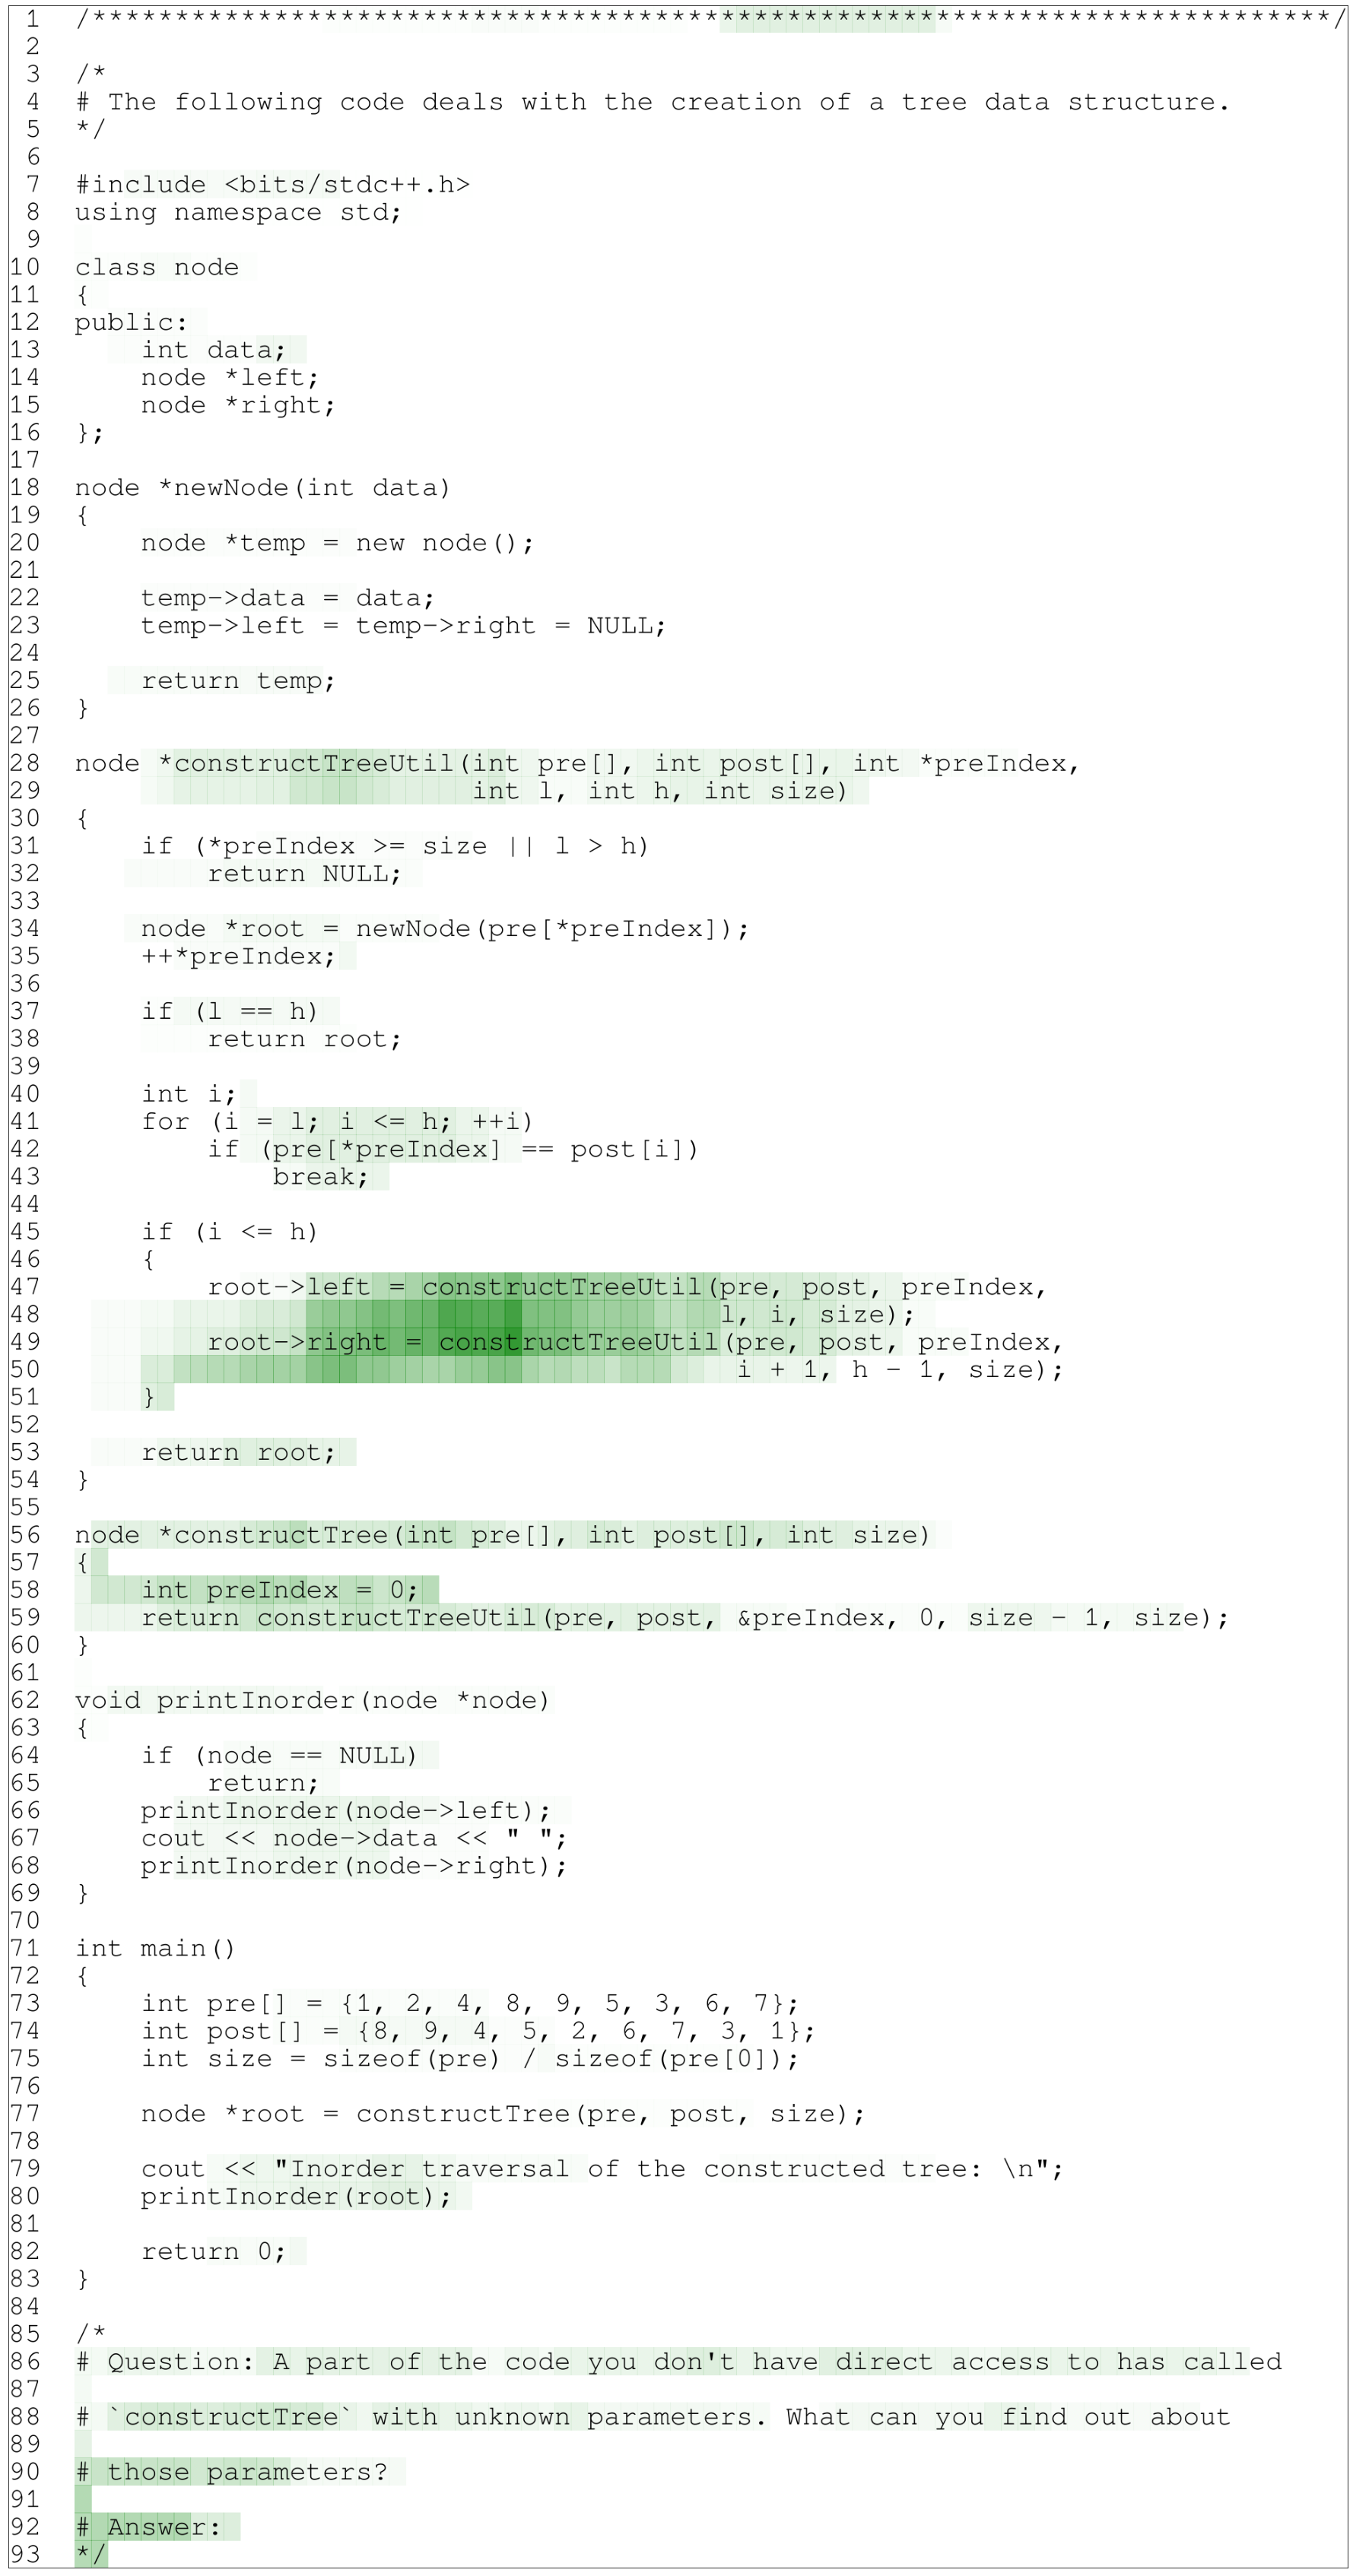

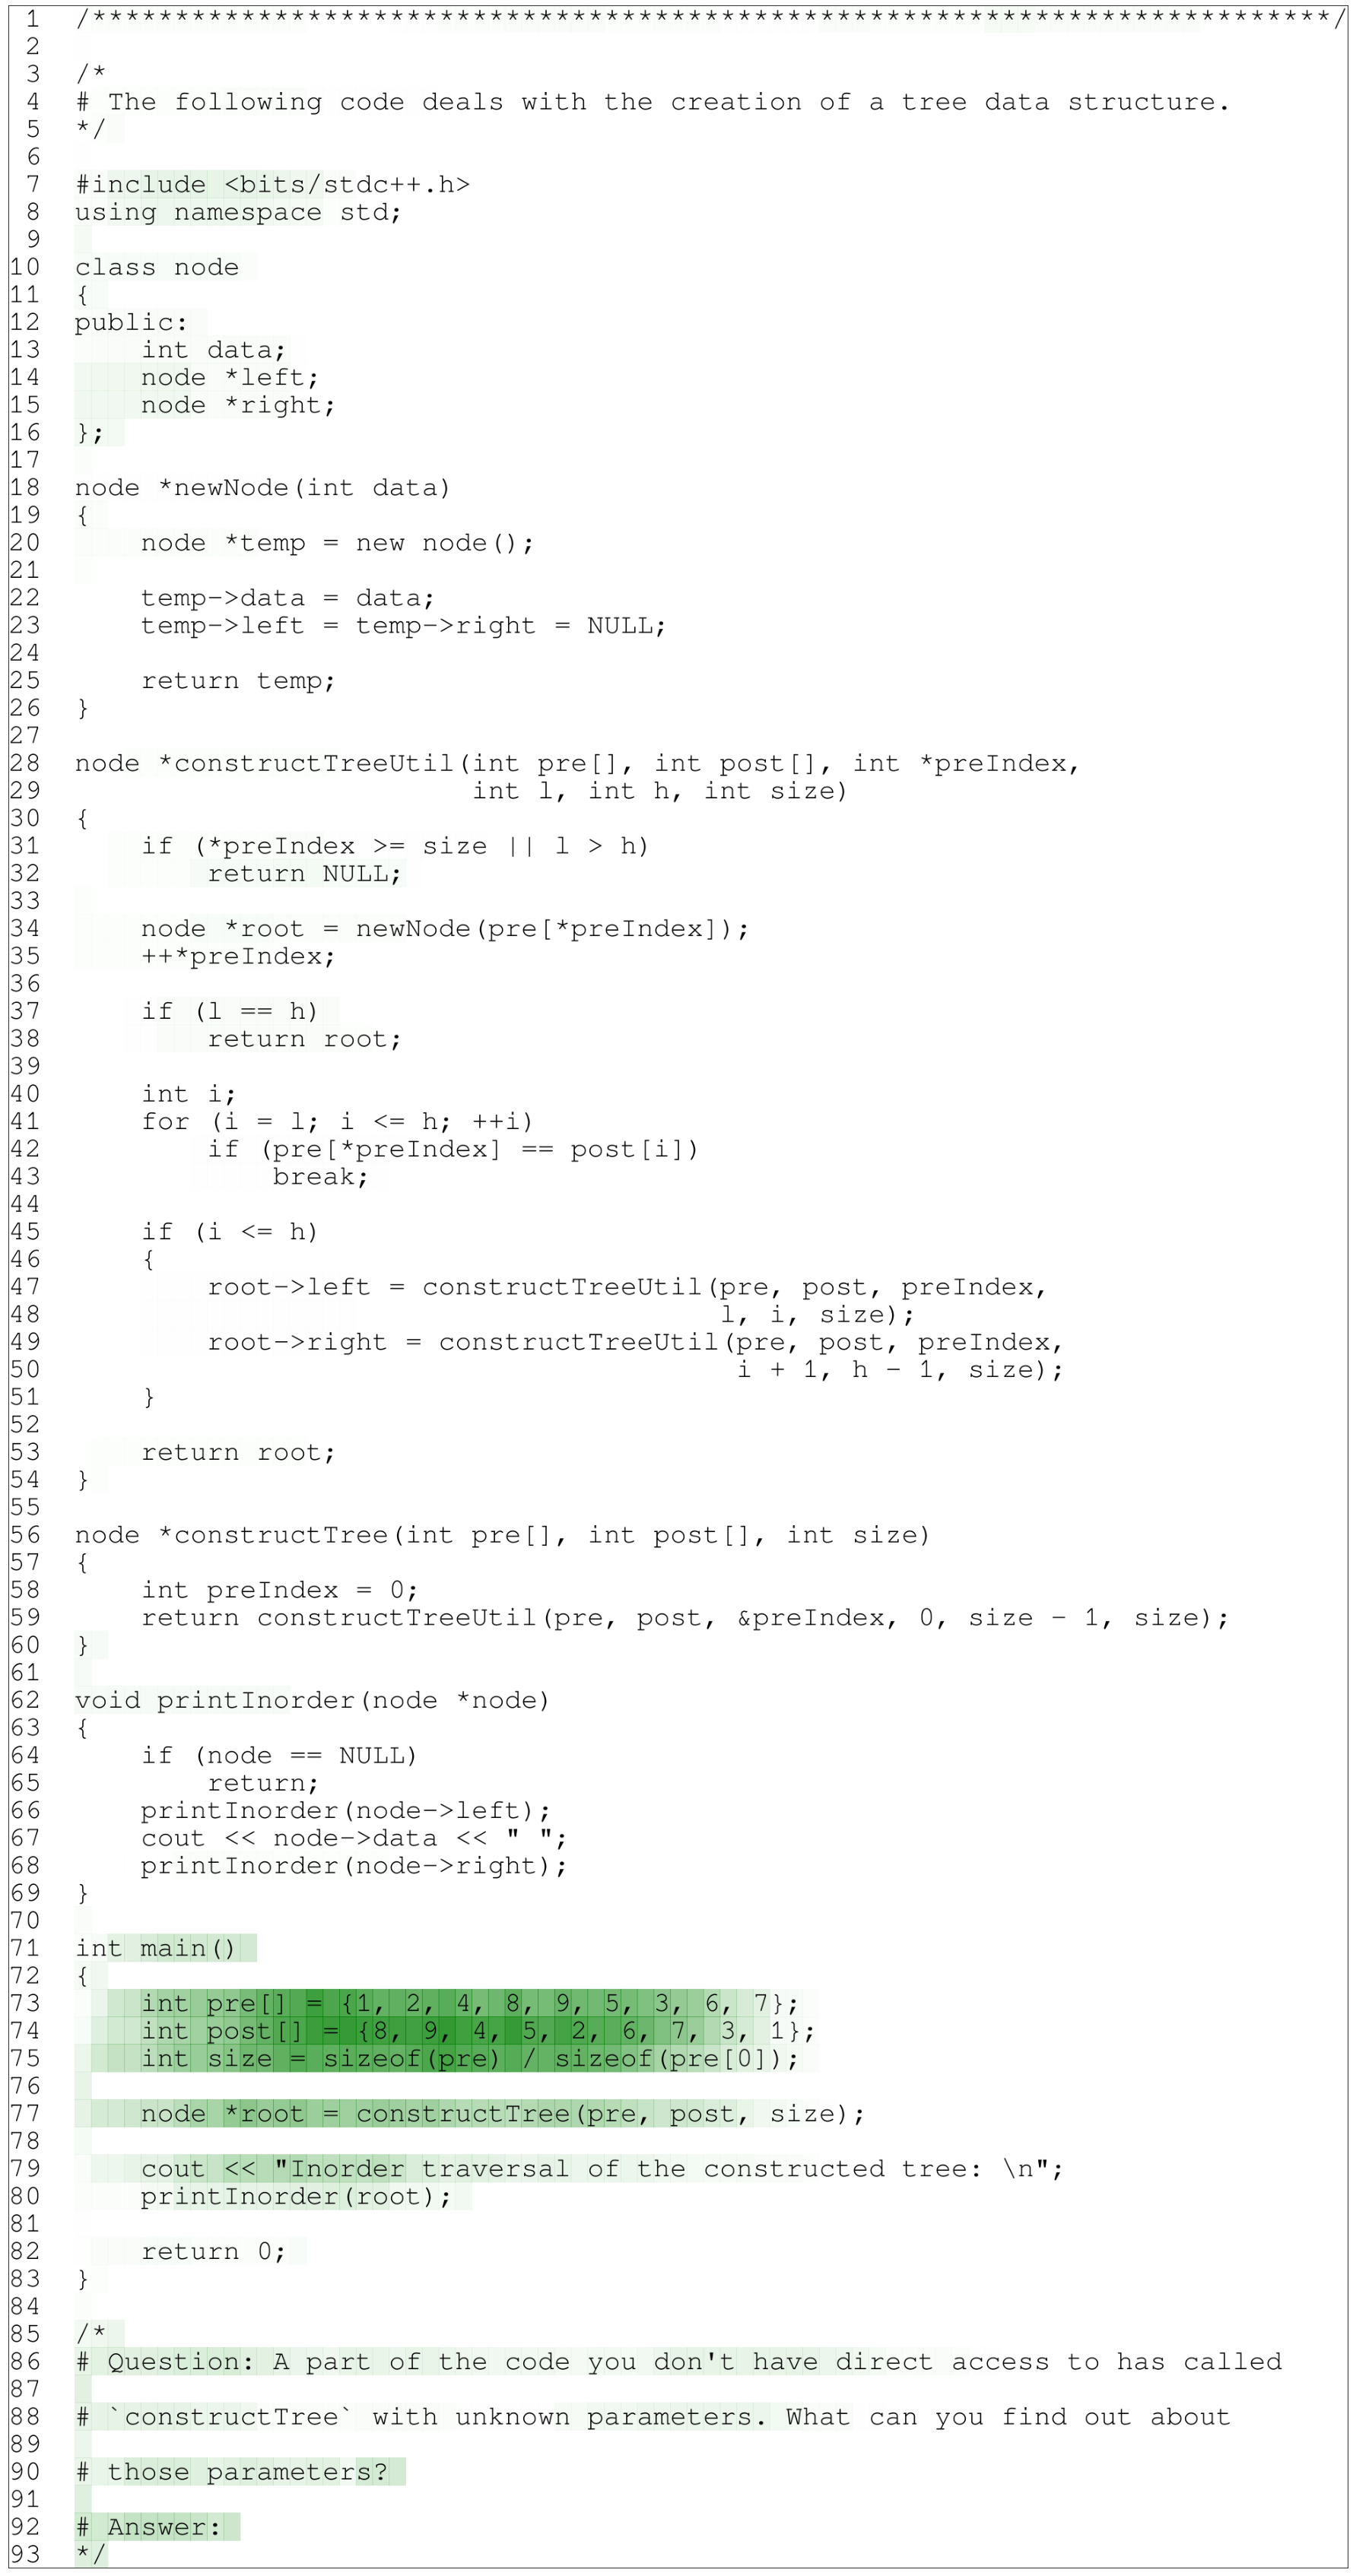

In [48]:

visualize_human_att_maps(
    path_human_a=f"../data/eye_tracking_attention/{HUMAN_EXPERIMENT}/UconsumerU_2.json",
    path_human_b=f"../data/eye_tracking_attention/{HUMAN_EXPERIMENT}/UquarterU_2.json"
)

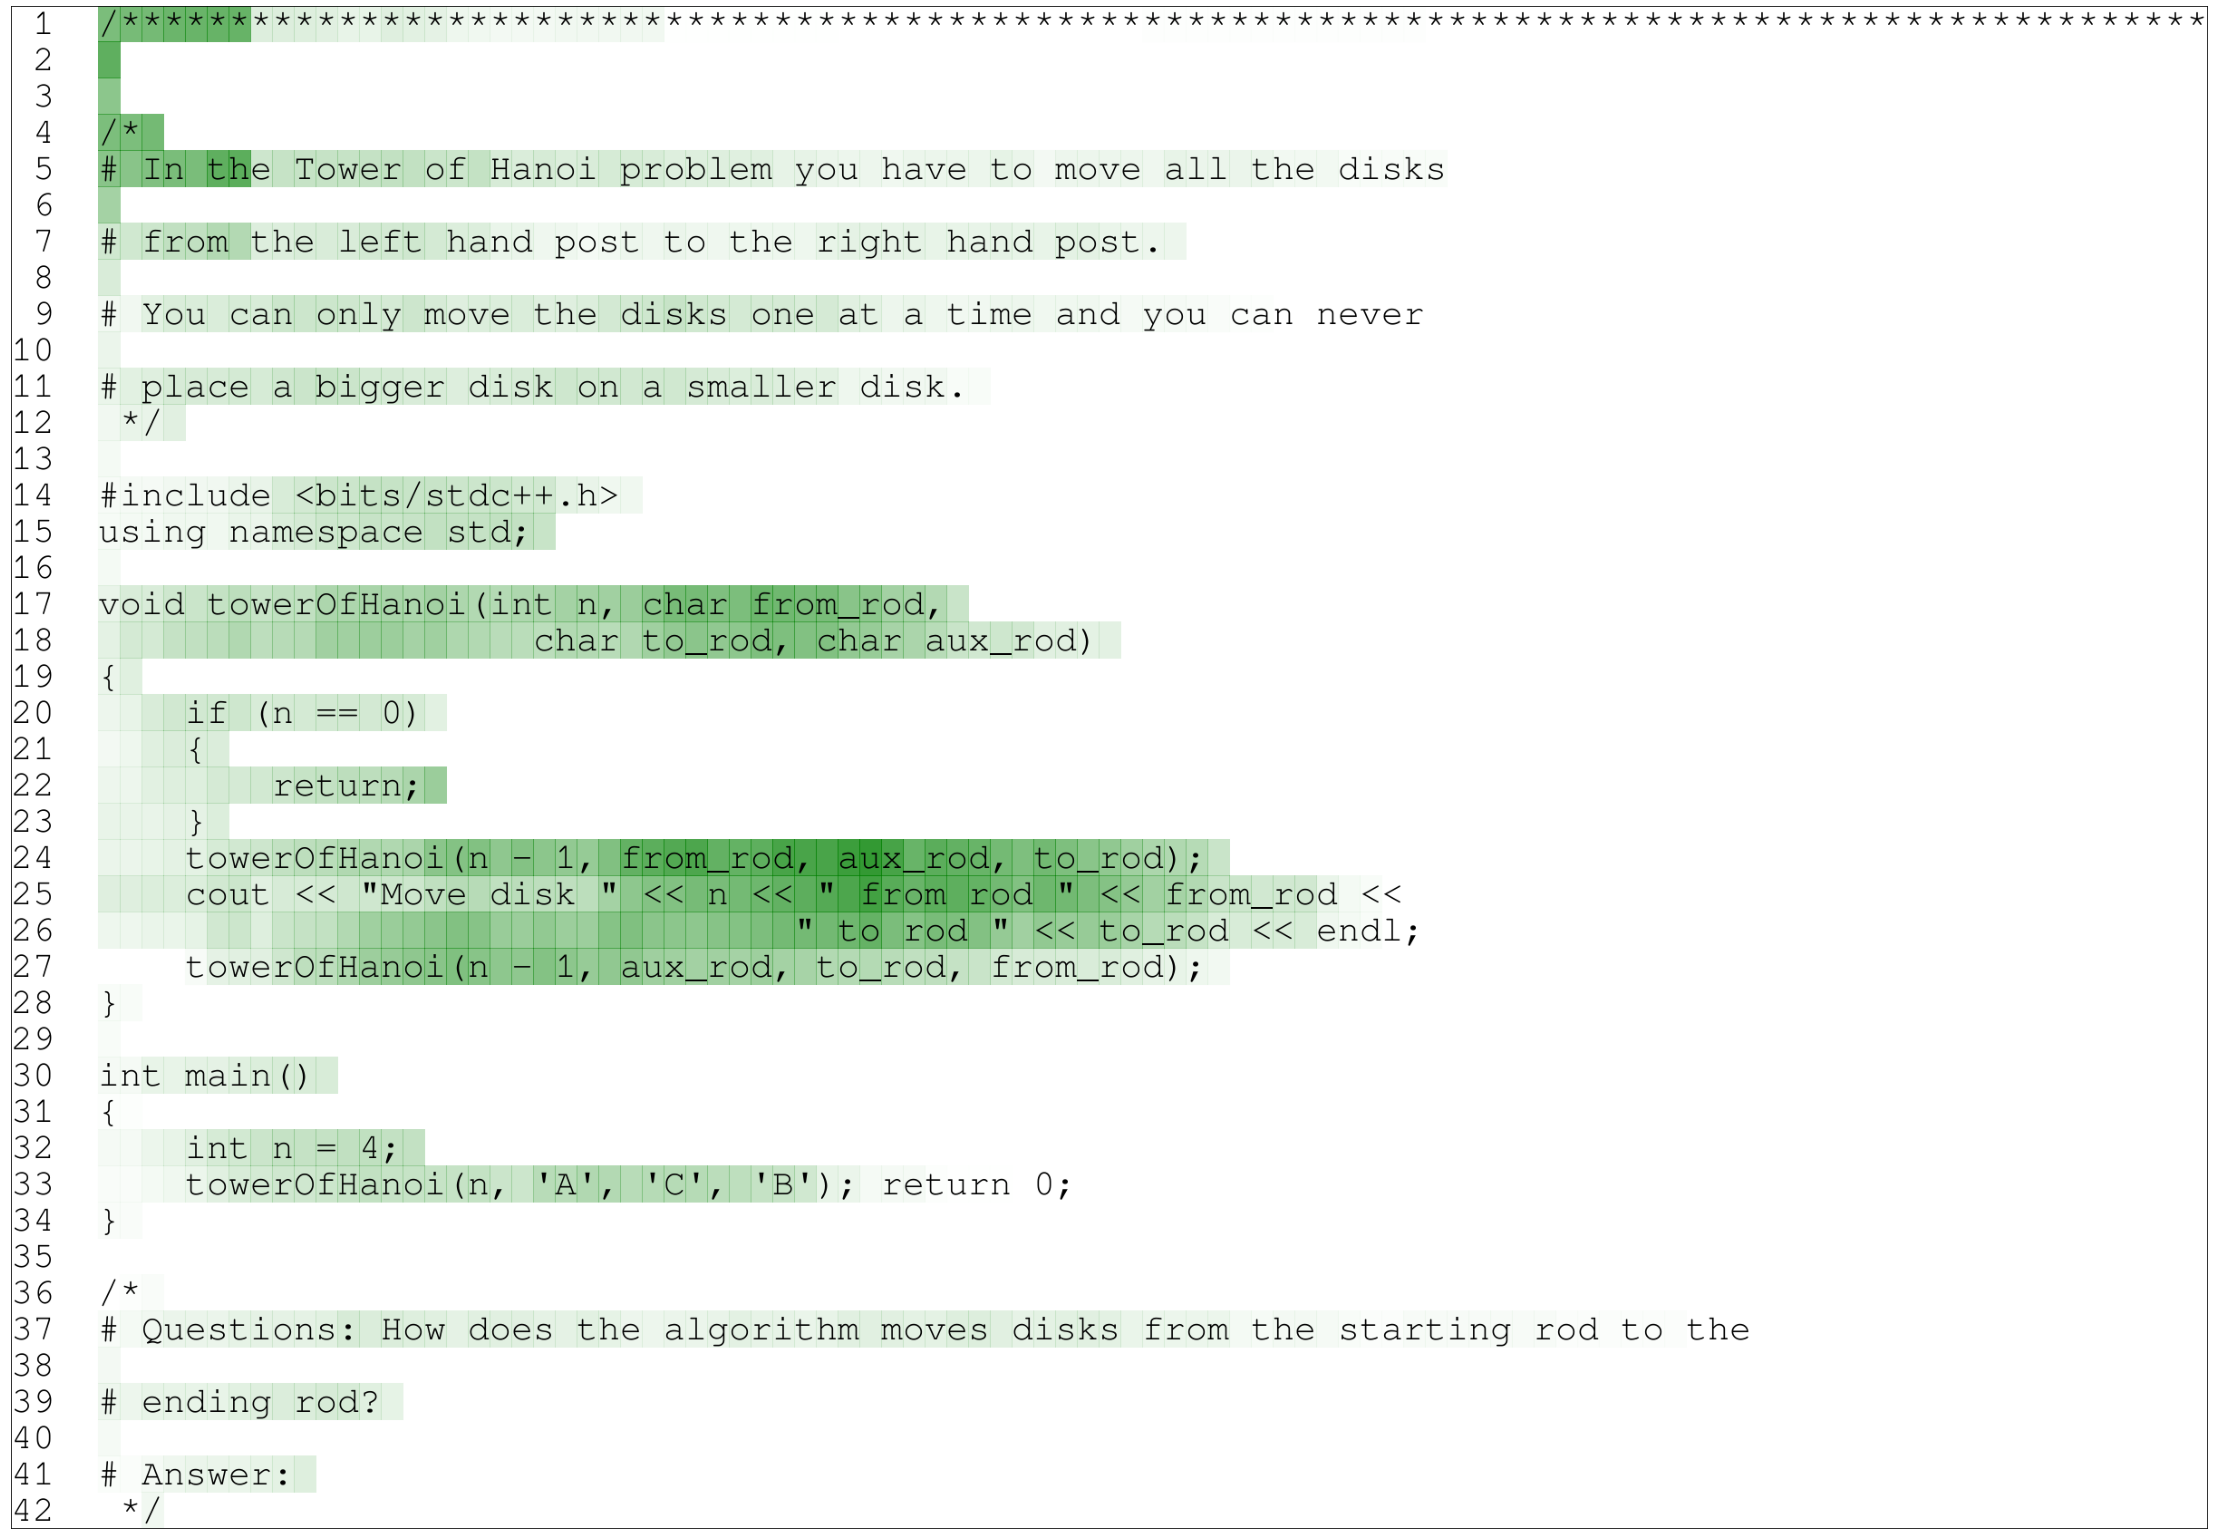

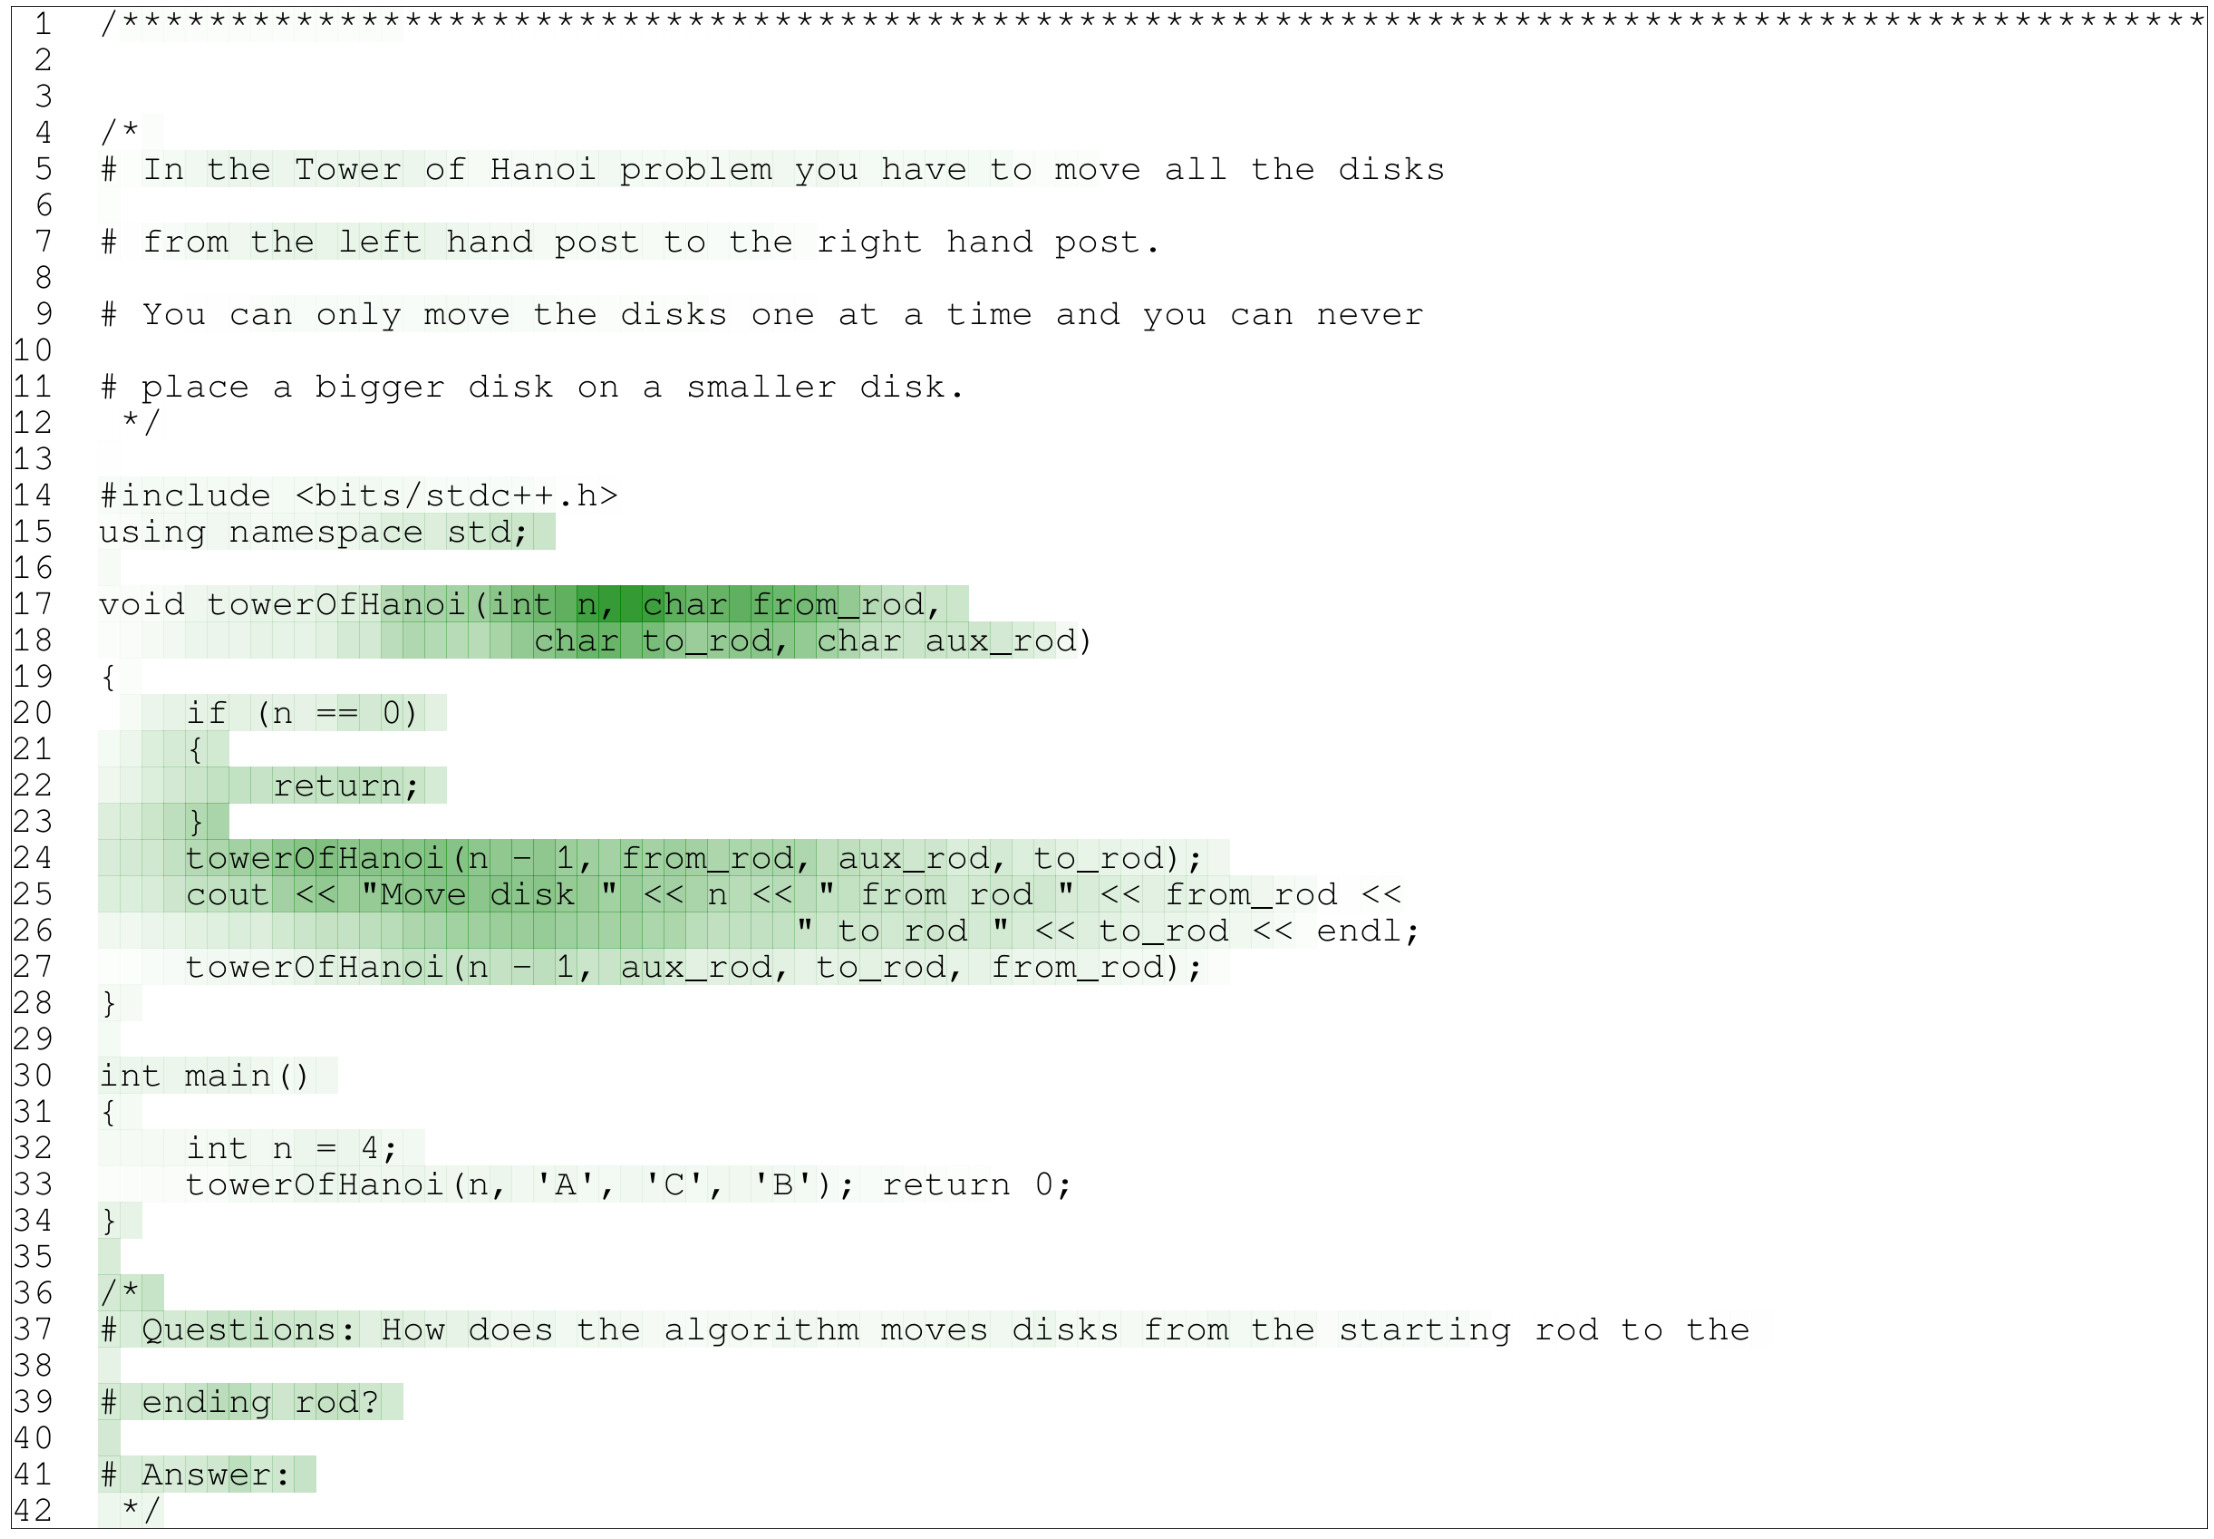

In [49]:

visualize_human_att_maps(
    path_human_a=f"../data/eye_tracking_attention/{HUMAN_EXPERIMENT}/UmonkU_0.json",
    path_human_b=f"../data/eye_tracking_attention/{HUMAN_EXPERIMENT}/UquarterU_0.json"
)

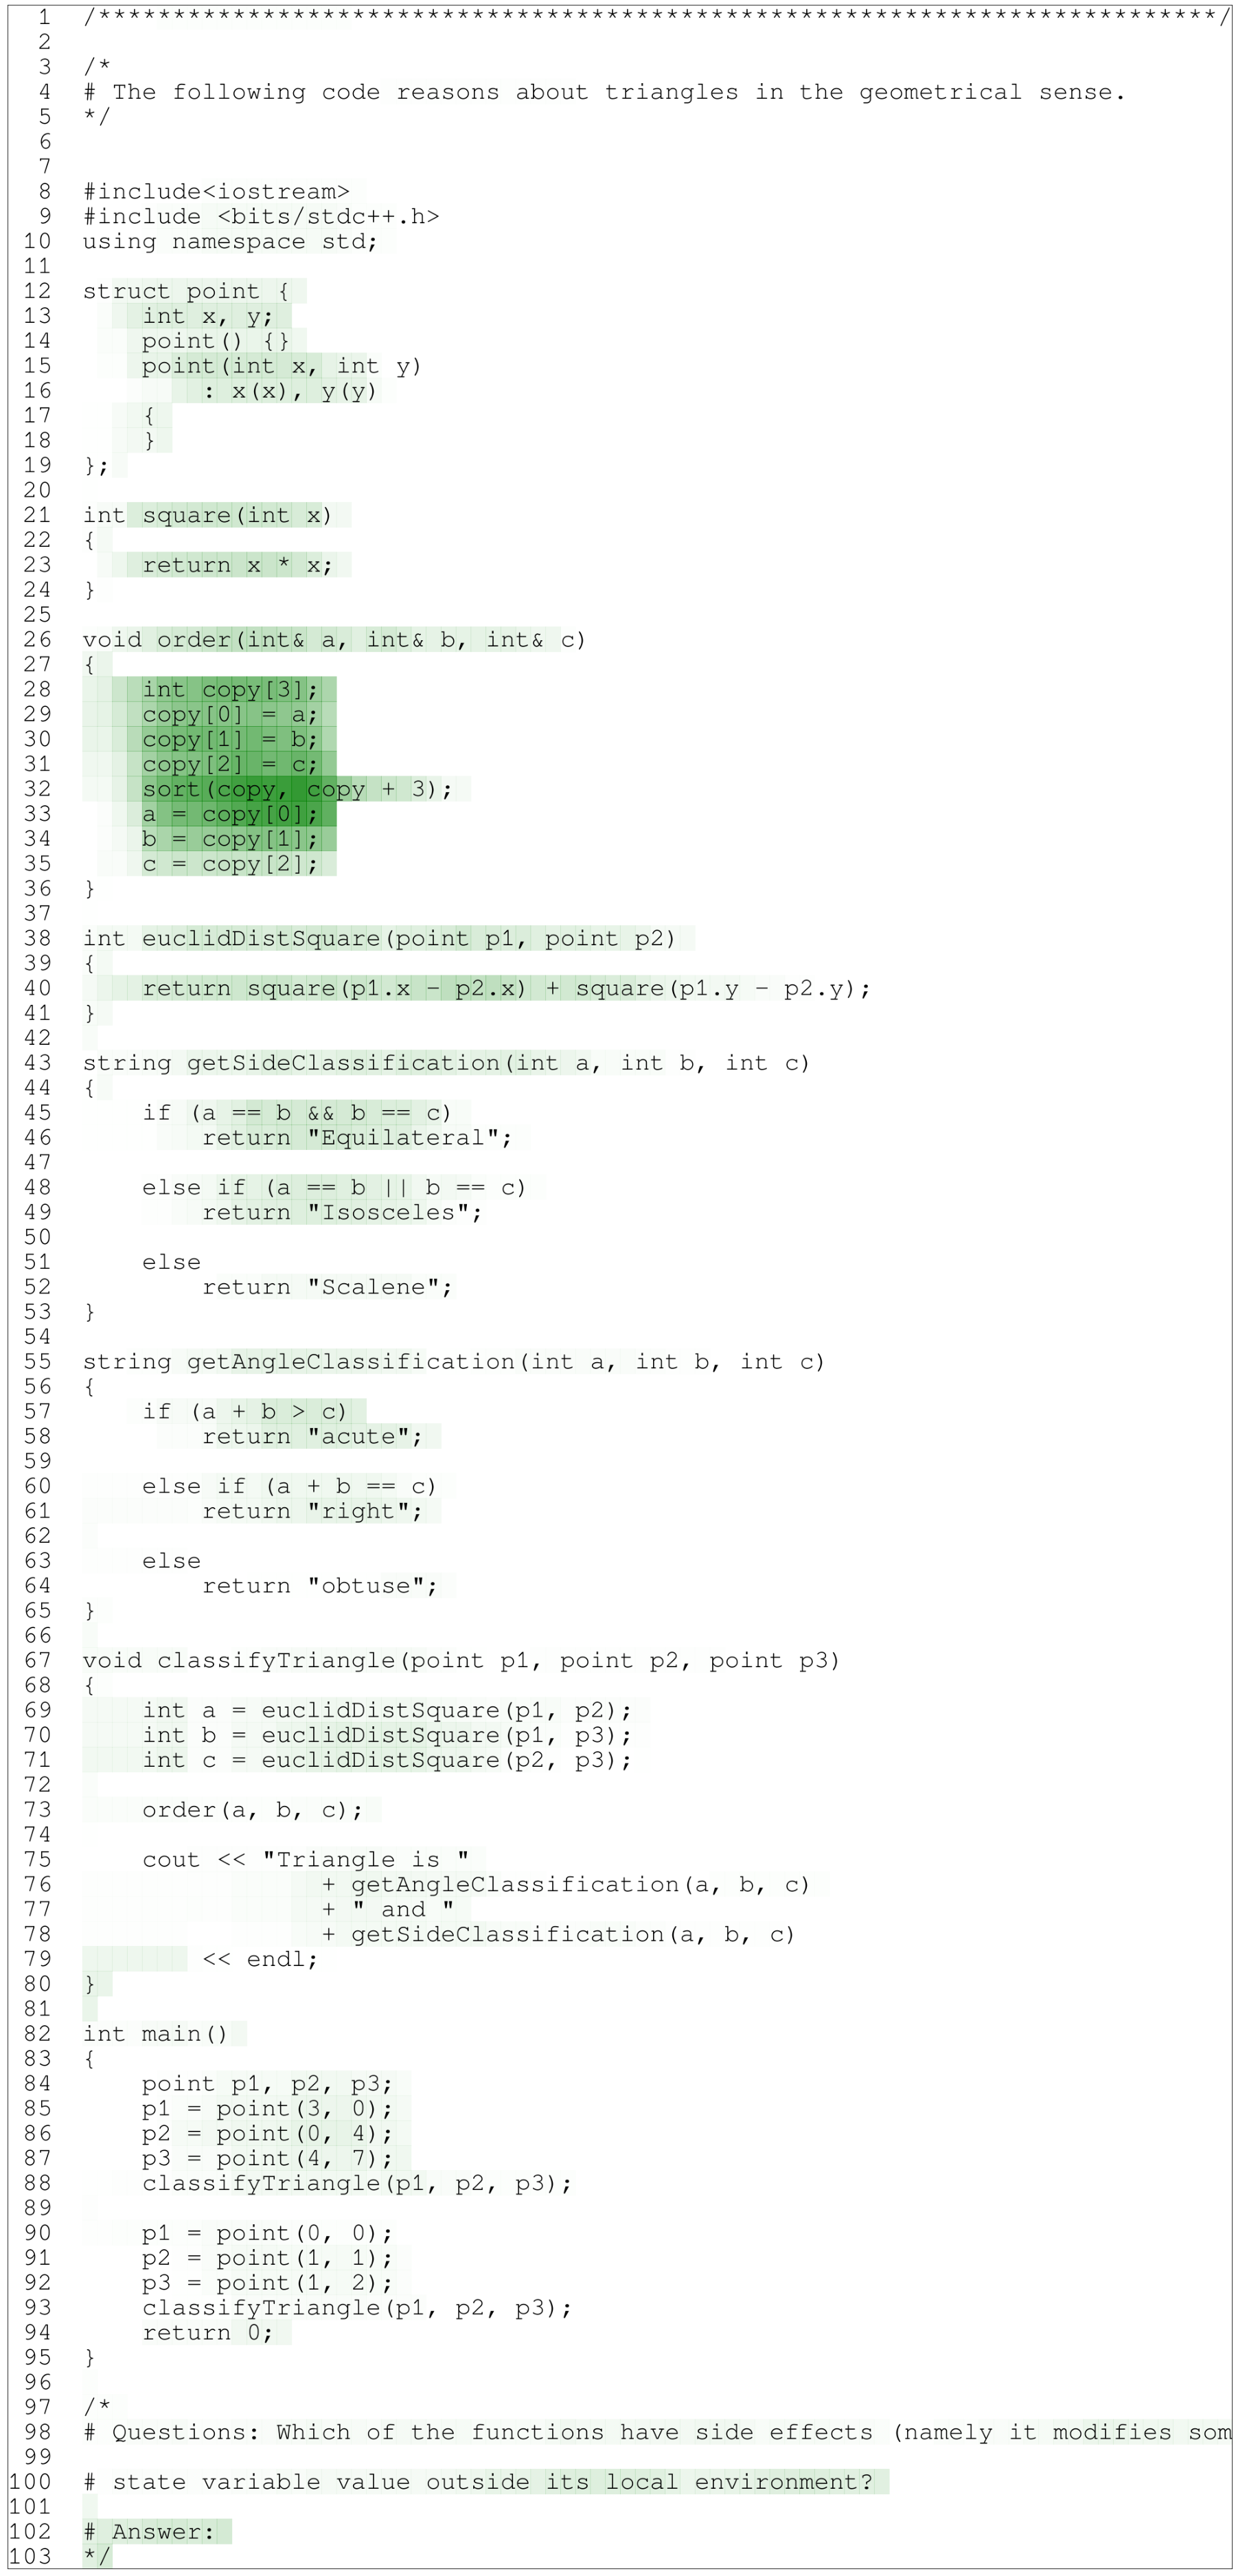

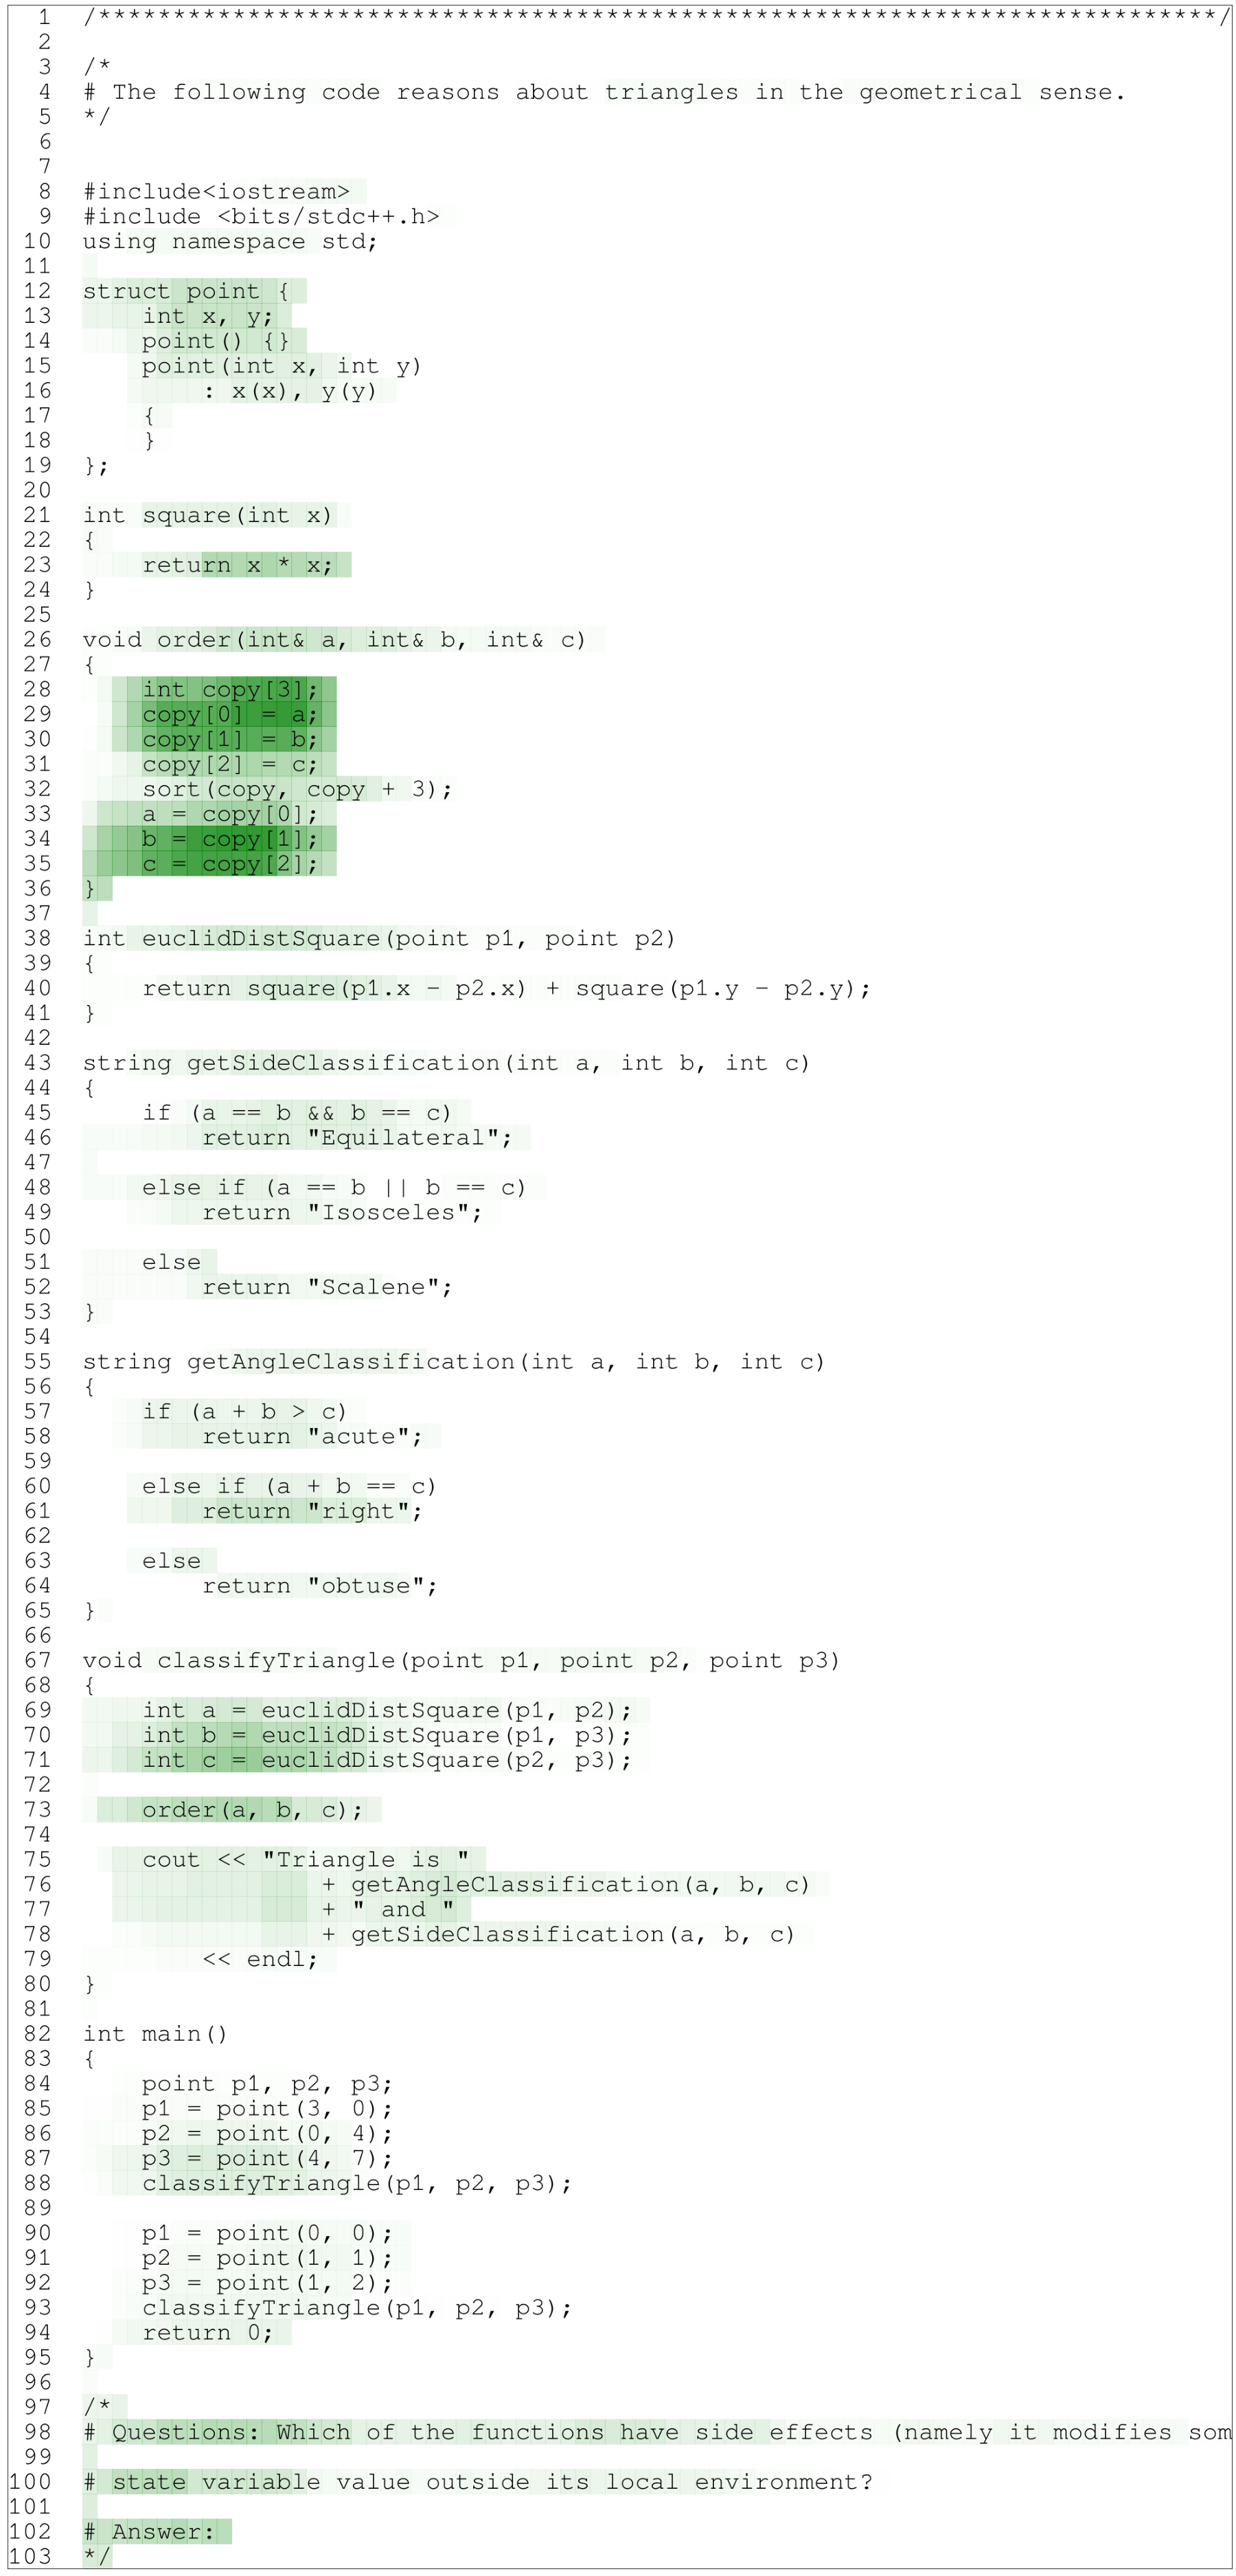

In [50]:
visualize_human_att_maps(
    path_human_a=f"../data/eye_tracking_attention/{HUMAN_EXPERIMENT}/UmonkU_2.json",
    path_human_b=f"../data/eye_tracking_attention/{HUMAN_EXPERIMENT}/UquarterU_3.json"
)